# Training models to predict next year's IFI tax for each French city

In this code, data is read and cleaned by recycling the code used in the data analysis: https://github.com/santiagopatinoserna/5YearFrenchWealthAnalysis.

Subsequently, the XGBoost model will be employed with the following hyperparameters (hp): #Best Parameters for XGBoost Model: {'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}. Both the model and the selection of hp are detailed in this notebook: https://github.com/santiagopatinoserna/TensorFlow_Prediction_5YearFrench_IFI/blob/main/Script/Model_selection_ML_NN.ipynb. Here, seven different models were tested, with hp optimization within each model, and ultimately, the best model was selected based on six different scores and cross-validation of the results. The results were reviewed by the GEN AI chat GPT via its API, which selected the best model by examining the results and acting in the role of an expert data scientist.

In this code, the XGBoost model will be launched with the selected hp, and a 5-year prediction will be carried out for each of the cities. It is also observed that certain outlier cities cannot be predicted with this model, so a basic Prophet model will be used, based on the predictive variable and GPS coordinates, as well as the distance to the nearest neighboring city.

## Data loading / Cleaning

As mentioned earlier, in this section we construct the DataFrame that will be used in the model.

In [1]:
# ----------------------------------------------------------------------------
# Mounting Google Drive for Data Access in Google Colab Environment
# ----------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os

# ----------------------------------------------------------------------------
# Constants
# ----------------------------------------------------------------------------
DATA_PATH = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'

# Data type definitions for each column during loading
DTYPE_DICT = {
    'Région': str, 'Départements': str, 'Code commune (INSEE)': str, 'Commune': str,
    'nombre de redevables': int, 'patrimoine moyen en €': int, 'impôt moyen en €': int,
    "patrimoine moyen en millions d'euros": float, "impôt moyen en milliers d'euros": float
}

# Dictionary for column name harmonization
HARMONIZATION_DICT = {
    'Départements': 'Département', 'Code commune (INSEE)': 'Code de la commune (INSEE)',
    'Commune': 'Nom de la commune', 'nombre de redevables': 'Nombre de redevables',
    'patrimoine moyen en €': 'Patrimoine moyen en €', 'impôt moyen en €': 'Impôt moyen en €'
}

# ----------------------------------------------------------------------------
# Data Loading
# ----------------------------------------------------------------------------
ificom_files = [f for f in os.listdir(DATA_PATH) if f.startswith('ificom')]
df_ificom = pd.concat([pd.read_excel(os.path.join(DATA_PATH, file), header=0, skiprows=1, dtype=DTYPE_DICT).assign(filename=file)
                       for file in ificom_files], ignore_index=True)

# ----------------------------------------------------------------------------
# Data Cleaning and Processing
# ----------------------------------------------------------------------------
# Harmonizing column names
for col, alt_col in HARMONIZATION_DICT.items():
    df_ificom[col] = df_ificom[col].fillna(df_ificom[alt_col])
df_ificom.drop(columns=list(HARMONIZATION_DICT.values()), inplace=True)

# Unit conversion and column redundancy removal
df_ificom['patrimoine moyen en €'] = df_ificom['patrimoine moyen en €'].fillna(
    df_ificom["patrimoine moyen en millions d'euros"] * 1_000_000)
df_ificom['impôt moyen en €'] = df_ificom['impôt moyen en €'].fillna(
    df_ificom["impôt moyen en milliers d'euros"] * 1_000)
df_ificom.drop(['patrimoine moyen en millions d\'euros', 'impôt moyen en milliers d\'euros'], axis=1, inplace=True)

# Additional data processing
df_ificom['Year'] = df_ificom['filename'].str.extract(r'-(\d{4})\.').astype(float)
df_ificom.rename(columns={
    'Région': 'Region', 'Départements': 'Department', 'Code commune (INSEE)': 'Commune_Code_INSEE', 'Commune': 'City',
    'nombre de redevables': 'Number_of_Taxpayers', 'patrimoine moyen en €': 'Average_Assets_in_Euro',
    'impôt moyen en €': 'Average_Tax_in_Euro', 'filename': 'Source_File'
}, inplace=True)
df_ificom['Commune_Code_INSEE'] = df_ificom['Commune_Code_INSEE'].str.replace(' ', '', regex=False)

# Merge and finalize 'City' column
unique_grouped_sorted = pd.read_excel(os.path.join(DATA_PATH, 'unique_grouped_sorted.xlsx'), dtype=str)[['Commune_Code_INSEE', 'Final_City']].drop_duplicates()
df_ificom = df_ificom.merge(unique_grouped_sorted, on='Commune_Code_INSEE', how='left')
df_ificom['City'] = df_ificom['City'].fillna(df_ificom['Final_City'])
df_ificom.drop(columns=['Final_City'], inplace=True)

# Constants for path definitions
PATH_IN = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
PATH_OUT = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/Dataout'

# Incorporate GPS coordinates into the dataframe
df_coordinates_gps = (pd.read_csv(os.path.join(PATH_IN, 'communes-departement-region.csv'),
                                  dtype={'code_commune_INSEE': str, 'latitude': float, 'longitude': float})
                      [['code_commune_INSEE', 'latitude', 'longitude']]
                      .rename(columns={'code_commune_INSEE': 'Commune_Code_INSEE'})
                      .assign(Commune_Code_INSEE=lambda df: df['Commune_Code_INSEE'].str.zfill(5)))

df_ificom = (df_ificom.merge(df_coordinates_gps, how='left', on='Commune_Code_INSEE')
             .assign(total_tax_per_city=lambda df: df['Average_Tax_in_Euro'] * df['Number_of_Taxpayers']))

# Save processed dataframe to file
df_ificom.to_csv(os.path.join(PATH_OUT, 'df_ificom.csv'), index=False)

# ----------------------------------------------------------------------------
# Machine Learning Preparations
# ----------------------------------------------------------------------------
# Library imports for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Data filtering for prediction model
df_ificom_clean = df_ificom.dropna(subset=['latitude', 'longitude', 'Year', 'total_tax_per_city'])

# Removing duplicate entries
df_ificom_clean = df_ificom_clean.drop_duplicates(keep='first').reset_index(drop=True)

# ----------------------------------------------------------------------------
# Feature Model Construction
# ----------------------------------------------------------------------------

In this section, we will construct the features that were identified as optimal
for the predictive model using XGBoost.



In [3]:
import numpy as np
import pandas as pd

# FEATURE 1: LAGGED DATA
df_ificom_clean = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'])
df_ificom_clean['total_tax_per_city_lag1'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)

# FEATURE 4: GENERAL STATISTICS
def compute_prior_statistics(row):
    prior_data = df_ificom_clean[(df_ificom_clean['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df_ificom_clean['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return pd.Series({'mean': None, 'median': None, 'min': None, 'max': None})
    return pd.Series({'mean': prior_data.mean(), 'median': prior_data.median(), 'min': prior_data.min(), 'max': prior_data.max()})

statistics_df = df_ificom_clean.apply(compute_prior_statistics, axis=1)
df_ificom_clean = pd.concat([df_ificom_clean, statistics_df], axis=1)

# FEATURE 5: AVERAGE DISTANCE TO THE 10 NEAREST CITIES
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

unique_cities = df_ificom_clean.drop_duplicates(subset='Commune_Code_INSEE')[['latitude', 'longitude', 'Commune_Code_INSEE']]
unique_distances = pd.DataFrame(index=unique_cities['Commune_Code_INSEE'], columns=unique_cities['Commune_Code_INSEE'])

for _, row1 in unique_cities.iterrows():
    for _, row2 in unique_cities.iterrows():
        unique_distances.at[row1['Commune_Code_INSEE'], row2['Commune_Code_INSEE']] = haversine_distance(row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude'])

# Convert unique_distances to numeric type
unique_distances = unique_distances.astype(float)

# Calculate the mean distances to the 10 nearest cities
mean_distances_to_10_nearest = {city: unique_distances.loc[city].nsmallest(11).iloc[1:].mean() for city in unique_cities['Commune_Code_INSEE']}
df_ificom_clean['mean_distance_to_10_nearest'] = df_ificom_clean['Commune_Code_INSEE'].map(mean_distances_to_10_nearest)

In [4]:
from sklearn.preprocessing import StandardScaler

# Reset the index for selected columns and drop the old index
df_ificom_clean = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City', 'Number_of_Taxpayers',
                                   'Average_Assets_in_Euro', 'Average_Tax_in_Euro', 'Source_File', 'Year', 'latitude',
                                   'longitude', 'total_tax_per_city', 'total_tax_per_city_lag1', 'mean', 'median',
                                   'min', 'max', 'mean_distance_to_10_nearest']].reset_index(drop=True)

# Extract identity columns for each city
ID_df = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City']]

# Define the features and the target variable
features = df_ificom_clean[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                            'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']].fillna(0)
target = df_ificom_clean['total_tax_per_city']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [5]:
def remove_outliers(df, column):
    """Remove outliers based on IQR for a specified column."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    outlier_communes = df.loc[
        (df[column] < lower_threshold) |
        (df[column] > upper_threshold),
        'Commune_Code_INSEE'
    ].unique()

    return df[~df['Commune_Code_INSEE'].isin(outlier_communes)].copy(), outlier_communes


def fill_na_values(df):
    """Fill NA values for numeric columns based on Commune_Code_INSEE groups."""
    df.sort_values(by=['Commune_Code_INSEE', 'Year'], inplace=True)

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df[col] = df.groupby('Commune_Code_INSEE')[col].fillna(method='ffill')

    return df.dropna()


# Clean outliers for 'total_tax_per_city'
df_ificom_clean_outliers, outlier_communes = remove_outliers(df_ificom_clean, 'total_tax_per_city')

# Fill NA values
df_ificom_clean_outliers = fill_na_values(df_ificom_clean_outliers)


# ----------------------------------------------------------------------------
# Constructing the DataFrame for Predictions
# ----------------------------------------------------------------------------


In this section, we build the DataFrame for the data that will be predicted.

The model and its subsequent predictions will exclude cities with outlier values.
Incorporating these outliers would negatively impact the model's performance for other cities.
Moreover, using a model trained without these outliers to predict their values would yield highly inaccurate results.



In [6]:
"""
Organizing and Preparing Data for Model Training and Prediction:

1. Sort the DataFrame by 'Commune_Code_INSEE' and 'Year'.
2. Determine the latest year recorded for each 'Commune_Code_INSEE'.
3. Construct a new DataFrame for predictions for the year following the most recent one.
   These entries will have the `to_be_predicted` flag set to True.
4. Combine the original DataFrame with the prediction DataFrame.
"""

# Identify 'Commune_Code_INSEE' values in df_ificom_clean that aren't in df_ificom_clean_outliers.
# These codes are flagged for risky forecasts.
missing_insee_codes = df_ificom_clean.loc[~df_ificom_clean['Commune_Code_INSEE'].isin(df_ificom_clean_outliers['Commune_Code_INSEE']), 'Commune_Code_INSEE'].unique()

# Step 1: Sort the DataFrame by 'Commune_Code_INSEE' and 'Year'
df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'], inplace=True)

# Step 2: Identify the most recent year for each 'Commune_Code_INSEE'
latest_years = df_ificom_clean.groupby('Commune_Code_INSEE')['Year'].max()

# Step 3: Prepare a DataFrame for predictions for the year following the latest recorded year
to_be_predicted_data = [{'Commune_Code_INSEE': commune, 'Year': year + 1, 'to_be_predicted': True}
                        for commune, year in latest_years.items()]
df_to_be_predicted = pd.DataFrame(to_be_predicted_data)

# Introduce the 'to_be_predicted' column to df_ificom_clean with default value as False
df_ificom_clean['to_be_predicted'] = False

# Step 4: Merge df_ificom_clean and df_to_be_predicted
df_ificom_clean_to_be_predicted = pd.concat([df_ificom_clean, df_to_be_predicted], ignore_index=True)


In [7]:
# ----------------------------------------------------------------------------
# Filling Static Variable Values for 'to_be_predicted' Rows
# ----------------------------------------------------------------------------

"""
For rows marked 'to_be_predicted', we fill static variable values using data from the previous year.
This ensures consistency and provides necessary information for predictions.
"""

df_sorted = df_ificom_clean_to_be_predicted.sort_values(by=["Commune_Code_INSEE", "Year"])

for i, row in df_sorted.iterrows():
    if row["to_be_predicted"]:
        prev_row = df_sorted.loc[
            (df_sorted["Commune_Code_INSEE"] == row["Commune_Code_INSEE"]) &
            (df_sorted["Year"] == row["Year"] - 1)
        ].iloc[0]

        for col in ["Region", "Department", "City", "latitude", "longitude", "mean_distance_to_10_nearest"]:
            df_sorted.at[i, col] = prev_row[col]

# ----------------------------------------------------------------------------
# Feature 1: Lagged Data - Constructing the Feature for Future Years
# ----------------------------------------------------------------------------
# Generate a single lag column based on the original data
df_ificom_clean_to_be_predicted['total_tax_per_city_lag1'] = df_ificom_clean_to_be_predicted.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)

# Reset the index to its original order
df_ificom_clean_to_be_predicted.reset_index(inplace=True)

# ----------------------------------------------------------------------------
# Feature 4: General Statistics
# ----------------------------------------------------------------------------
# Compute aggregate statistics using historical data to prevent data leakage.

def compute_prior_statistics(row):
    prior_data = df_ificom_clean_to_be_predicted[
        (df_ificom_clean_to_be_predicted['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) &
        (df_ificom_clean_to_be_predicted['Year'] < row['Year'])
    ]['total_tax_per_city']

    if prior_data.empty:
        return pd.Series({
            'mean': np.nan,
            'median': np.nan,
            'min': np.nan,
            'max': np.nan
        })

    return pd.Series({
        'mean': prior_data.mean(),
        'median': prior_data.median(),
        'min': prior_data.min(),
        'max': prior_data.max()
    })

statistics_df = df_ificom_clean_to_be_predicted.apply(compute_prior_statistics, axis=1)
df_ificom_clean_to_be_predicted[['mean', 'median', 'min', 'max']] = statistics_df


# ----------------------------------------------------------------------------
# Preparing Data for Predictions
# ----------------------------------------------------------------------------
# Extract rows marked 'to_be_predicted' and define feature set

features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
            'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']

X_tobe_predicted = df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']][features]
ID_tobe_predicted = df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']][['Commune_Code_INSEE', 'Year']]

## Training model without outliers

In this section, we'll train a predictive model using data that has been cleaned of outliers. By eliminating extreme values that can skew the data, we aim to improve the accuracy and robustness of the model. This approach ensures that the model is influenced primarily by the general trend of the data rather than extreme, possibly anomalous, values.

In [8]:
# Preparing and Scaling Data for Modeling
selected_features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1', 'mean',
                     'median', 'min', 'max', 'mean_distance_to_10_nearest']

X = df_ificom_clean_outliers[selected_features]
y = df_ificom_clean_outliers['total_tax_per_city']

# Scaling the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Initializing and Training the XGBoost Model with Optimal Hyperparameters
import xgboost as xgb

# Optimal Hyperparameters for XGBoost Model
optimal_params = {
    'colsample_bytree': 0.4,
    'gamma': 0,
    'learning_rate': 0.05,
    'max_depth': 3,
    'n_estimators': 250,
    'subsample': 0.5
}

# Training the XGBoost Model
xgb_regressor = xgb.XGBRegressor(**optimal_params)
xgb_regressor.fit(X_scaled, y_scaled)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Predicting values for the first Year + 1

In this section, we'll use the trained model to forecast values for the year immediately following the latest year in our dataset. This prediction aims to provide insights into potential tax outcomes for the subsequent year based on the established patterns and trends in the data.

In [9]:
# Scale the DataFrame prepared for prediction
X_tobe_predicted_scaled = scaler.transform(X_tobe_predicted)

# Generate predictions
y_pred_scaled = xgb_regressor.predict(X_tobe_predicted_scaled)

# Convert the scaled predictions back to their original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Create a DataFrame with the predicted values
predictions_df = pd.DataFrame({
    'Commune_Code_INSEE': ID_tobe_predicted['Commune_Code_INSEE'].values,
    'Predicted_total_tax_per_city': y_pred.ravel()
})

# Merge the features and predictions into a new DataFrame for looped predictions
df_predicted = pd.concat([X_tobe_predicted.reset_index(drop=True), predictions_df], axis=1)

# Function to update a base DataFrame using values from an update DataFrame
def replace_values_using_iloc(df_base, df_update):
    for _, row in df_update.iterrows():
        # Locate the corresponding row in the base DataFrame
        row_index = df_base[
            (df_base['Year'] == row['Year']) &
            (df_base['Commune_Code_INSEE'] == row['Commune_Code_INSEE'])
        ].index[0]

        # Replace values in the base DataFrame using data from the update DataFrame
        for col in df_update.columns:
            if col not in ['Year', 'Commune_Code_INSEE']:
                col_index = df_base.columns.get_loc(col)
                df_base.iloc[row_index, col_index] = row[col]

    return df_base

# Update the main DataFrame using the predicted values
df_ificom_clean_to_be_predictedV2 = replace_values_using_iloc(df_ificom_clean_to_be_predicted.copy(), df_predicted.rename(columns={'Predicted_total_tax_per_city':'total_tax_per_city'}))

# Label rows based on whether they contain predicted values
df_ificom_clean_to_be_predictedV2['predicted'] = df_ificom_clean_to_be_predictedV2['to_be_predicted'].apply(lambda x: True if x else False)
df_ificom_clean_to_be_predictedV2['to_be_predicted'] = False


### 5-Year Predictive Forecasting

Using the trained XGBoost model, this code predicts tax values for each city over the next five years. Predictions are made year-by-year, updating the dataset with each new forecasted value.

In [10]:
def get_data_for_next_year(df):
    """
    Get data for the next year based on the most recent year's data.
    """
    df_sorted = df.sort_values(by=['Commune_Code_INSEE', 'Year'])
    latest_years = df_sorted.groupby('Commune_Code_INSEE')['Year'].max()

    next_year_data = [{'Commune_Code_INSEE': commune, 'Year': year + 1, 'to_be_predicted': True} for commune, year in latest_years.items()]
    return pd.DataFrame(next_year_data)

def fill_values_from_previous_year(df):
    """
    Fill static values using data from the previous year.
    """
    for i, row in df.iterrows():
        if row["to_be_predicted"]:
            prev_row = df[(df["Commune_Code_INSEE"] == row["Commune_Code_INSEE"]) & (df["Year"] == row["Year"] - 1)].iloc[0]
            for col in ["Region", "Department", "City", "latitude", "longitude", "mean_distance_to_10_nearest"]:
                df.at[i, col] = prev_row[col]
    return df

def append_lagged_data(df):
    """
    Append lagged data for the 'total_tax_per_city' column.
    """
    col_name = 'total_tax_per_city_lag1'
    df[col_name] = df.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)
    return df

def compute_statistics_for_previous_data(row, df):
    """
    Compute statistics using data from previous years.
    """
    prior_data = df[(df['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return {'mean': None, 'median': None, 'min': None, 'max': None}
    else:
        return {'mean': prior_data.mean(), 'median': prior_data.median(), 'min': prior_data.min(), 'max': prior_data.max()}

def append_general_statistics(df):
    """
    Append general statistics to the dataframe.
    """
    statistics_df = df.apply(lambda row: compute_statistics_for_previous_data(row, df), axis=1, result_type='expand')
    df[['mean', 'median', 'min', 'max']] = statistics_df[['mean', 'median', 'min', 'max']]
    return df

def perform_prediction_with_xgboost(df, scaler, xgb_regressor, y_scaler):
    """
    Use the XGBoost model to perform predictions.
    """
    features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']
    X = df[df['to_be_predicted']==True][features]
    X_scaled = scaler.transform(X)
    y_pred_scaled = xgb_regressor.predict(X_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    return y_pred

def incorporate_predictions_into_dataframe(df, y_pred):
    """
    Incorporate the predicted values into the main dataframe.
    """
    df.loc[df['to_be_predicted'], 'total_tax_per_city'] = y_pred.ravel()
    df['predicted'] = df['to_be_predicted'].copy()
    df['to_be_predicted'] = False
    df = df.drop(columns=[col for col in ['level_0', 'index'] if col in df.columns], errors='ignore')
    return df

for _ in range(4):
    # Add rows for the next year's predictions
    df_next_year = get_data_for_next_year(df_ificom_clean_to_be_predictedV2)
    df_ificom_clean_to_be_predictedV2 = pd.concat([df_ificom_clean_to_be_predictedV2, df_next_year], ignore_index=True).sort_values(by=["Commune_Code_INSEE", "Year"])

    # Fill values using data from the previous year
    df_ificom_clean_to_be_predictedV2 = fill_values_from_previous_year(df_ificom_clean_to_be_predictedV2)

    # Add lagged data
    df_ificom_clean_to_be_predictedV2 = append_lagged_data(df_ificom_clean_to_be_predictedV2)

    # Add statistics
    df_ificom_clean_to_be_predictedV2 = append_general_statistics(df_ificom_clean_to_be_predictedV2)

    # Predict using XGBoost
    y_pred = perform_prediction_with_xgboost(df_ificom_clean_to_be_predictedV2, scaler, xgb_regressor, y_scaler)

    # Incorporate predictions into the dataframe
    df_ificom_clean_to_be_predictedV2 = incorporate_predictions_into_dataframe(df_ificom_clean_to_be_predictedV2, y_pred)

df_ificom_clean_to_be_predictedV2.loc[df_ificom_clean_to_be_predictedV2['Number_of_Taxpayers'].isna(), 'predicted'] = True


#### Graph results

This visualization showcases the prediction outcomes for a subset of 10 cities.
It's important to note that these cities were randomly chosen and do not include any outliers.





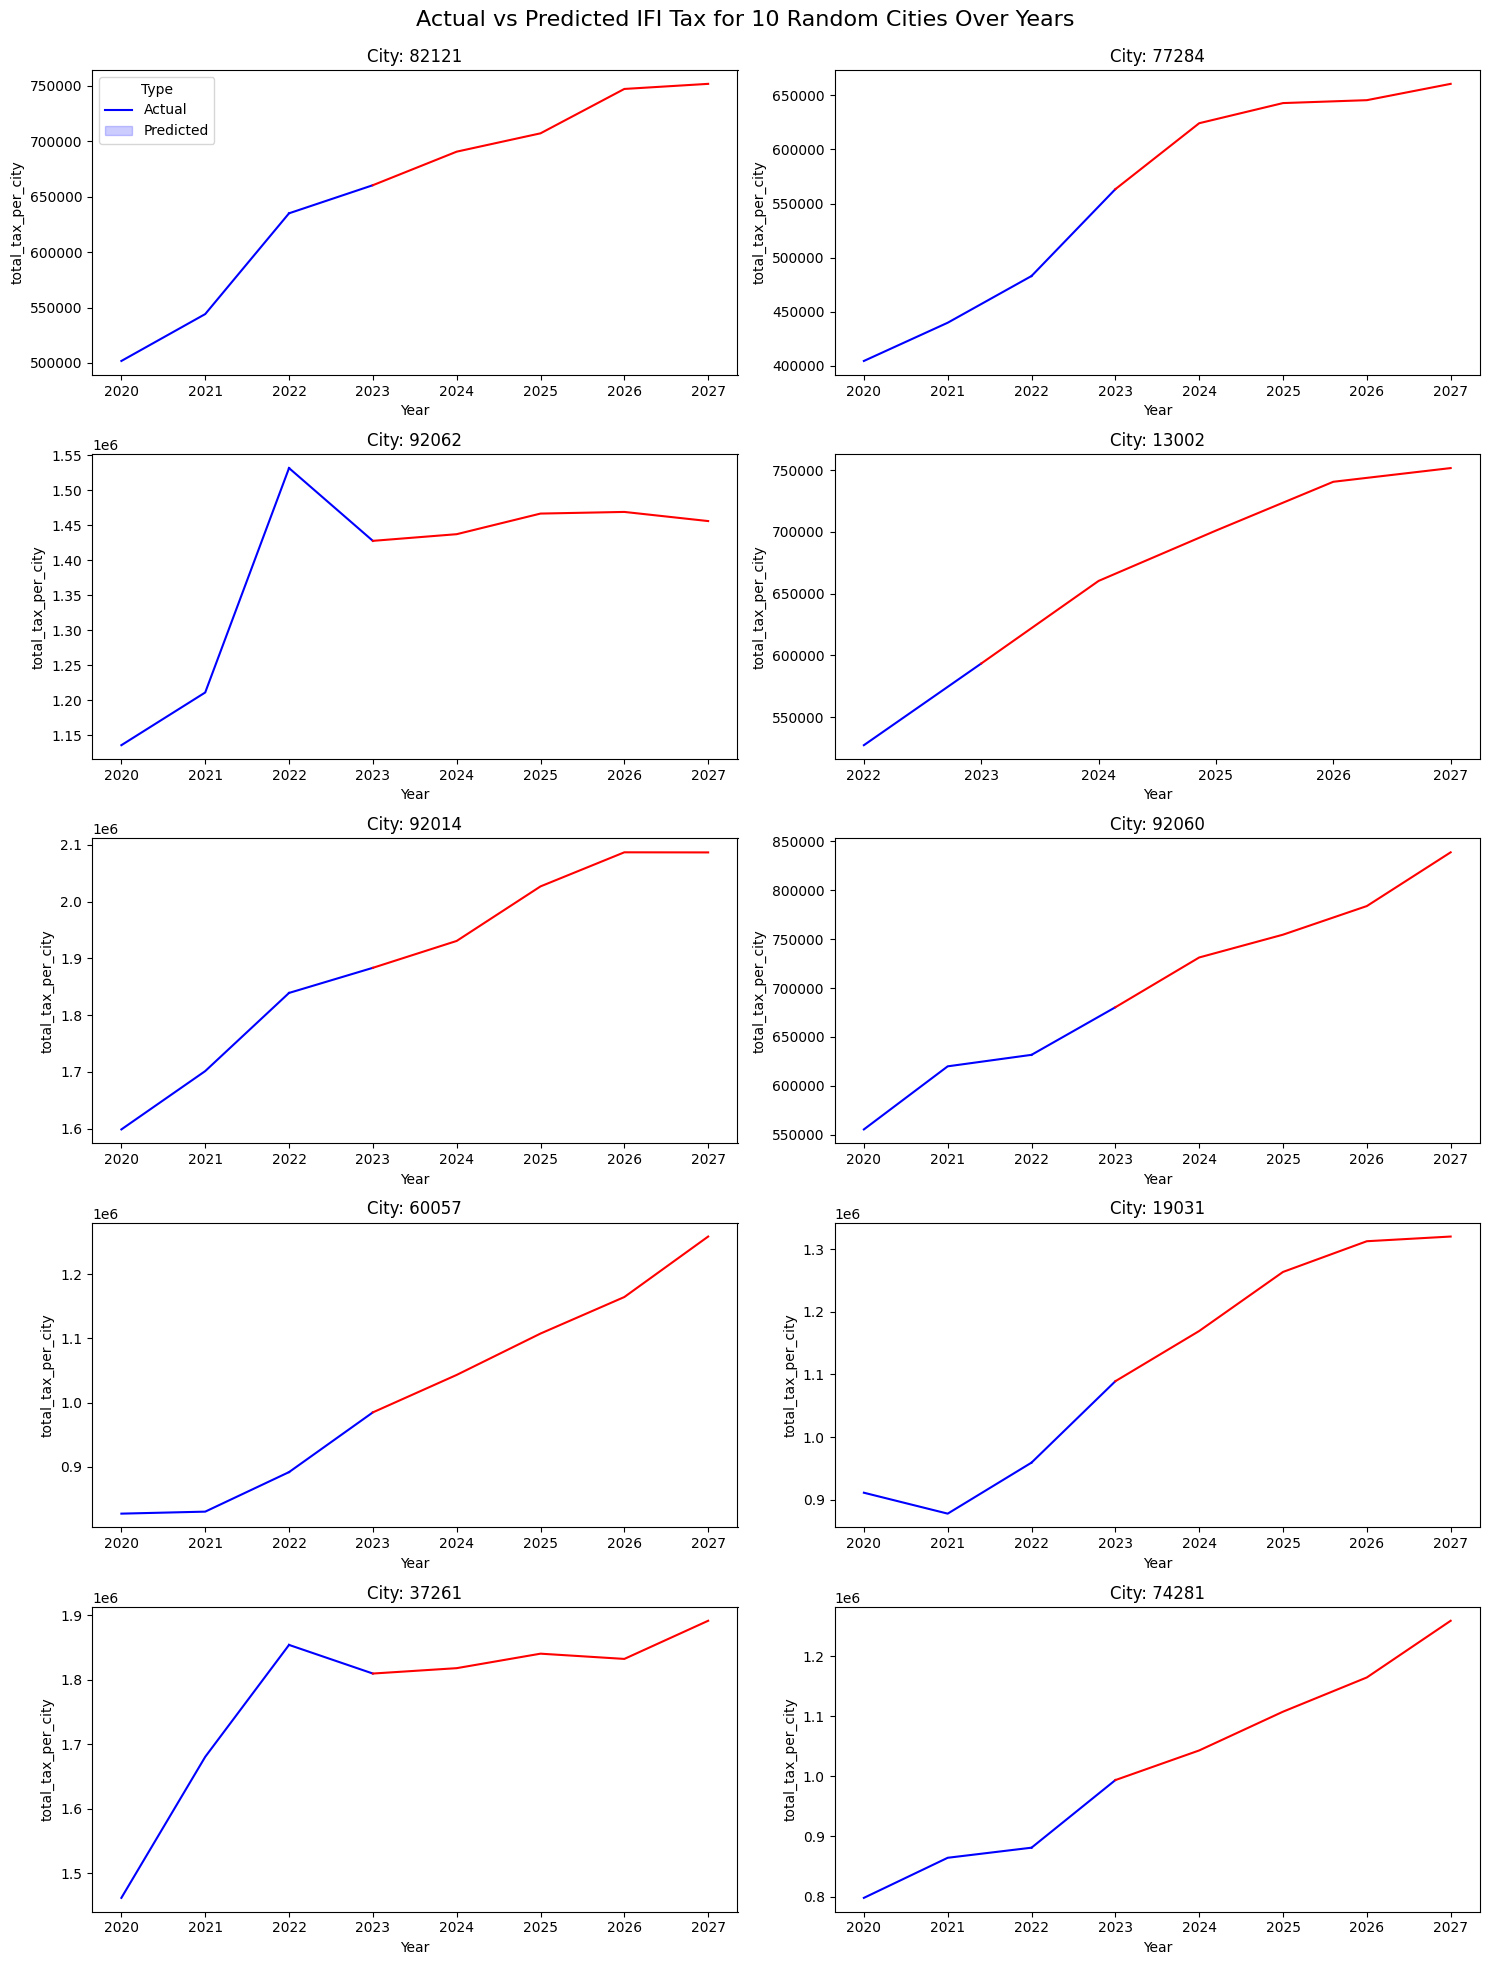

In [11]:
#### Visualizing Prediction Results for IFI Tax

# This visualization presents the actual vs. predicted IFI tax for 10 randomly selected cities over the years.
# The blue line represents the actual data while the red line shows the predicted values.
# It's essential to recognize that the cities chosen for this illustration do not include any outliers.

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the relative growth rate for each city.
growth_rates = {}
for city in df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].drop_duplicates():
    city_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'] == city]
    initial_value = city_data['total_tax_per_city'].iloc[0]
    final_value = city_data['total_tax_per_city'].iloc[-1]
    growth_rates[city] = (final_value - initial_value) / initial_value

growth_rates_df = pd.DataFrame(list(growth_rates.items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# Exclude cities that are in outlier_communes
filtered_growth_rates_df = growth_rates_df[~growth_rates_df['Commune_Code_INSEE'].isin(outlier_communes)]

# 2. Randomly select 10 cities from the filtered data.
random_10_cities = filtered_growth_rates_df.sample(10)['Commune_Code_INSEE'].tolist()
selected_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(random_10_cities)].sort_values(by='Year')

# 3. Plot these 10 cities with a continuous line that changes color.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for idx, city in enumerate(random_10_cities):
    row, col = divmod(idx, 2)
    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city]

    # Plot all the data where predicted = False
    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)

    # Connect the last point where predicted = False to the first point where predicted = True
    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b')

    # Plot all the data where predicted = True
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Type', labels=['Actual', 'Predicted'])
plt.suptitle("Actual vs Predicted IFI Tax for 10 Random Cities Over Years", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the space to fit the suptitle
plt.show()


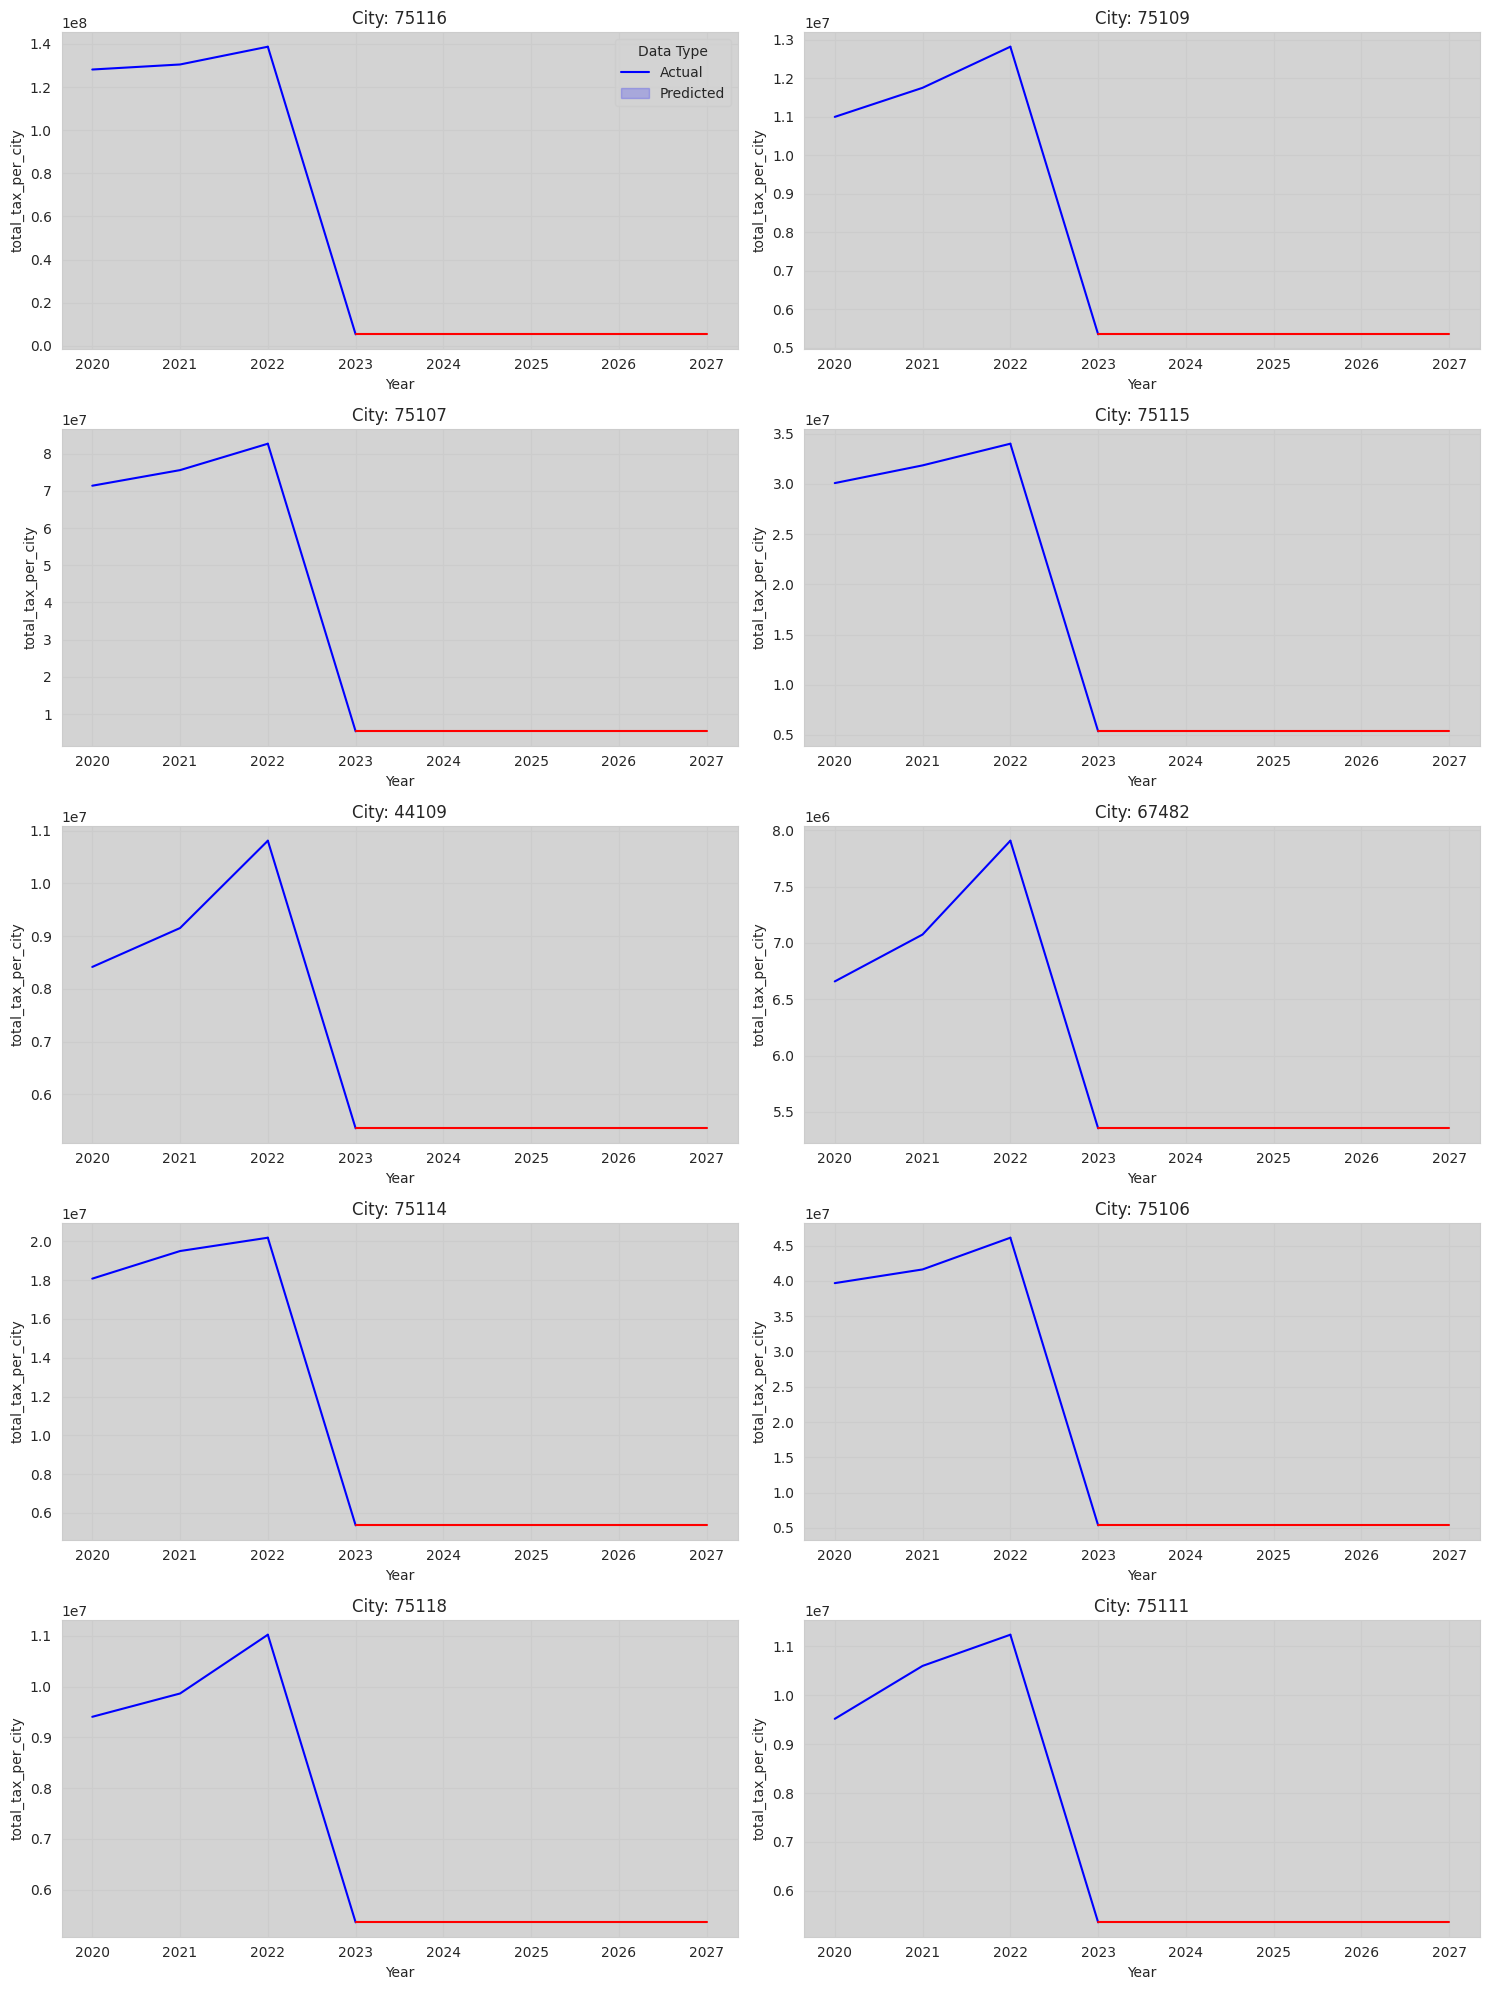

In [12]:
'''
For review:

This graph displays the outlier cities along with their predictions using the XGBoost model.
As initially indicated, these cities were not used to train the model due to their exceptionally high values.
This could potentially impact the model's performance for other cities.
However, it's evident that the model predicts values that are inconsistent with the time series for each city.
Consequently, a different model will be utilized for these predictions.
'''

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visual style
sns.set_style("whitegrid", {'axes.facecolor': 'lightgray'})

def extract_outlier_data(df, outlier_communes):
    """Extract data for outlier cities."""
    return df[df['Commune_Code_INSEE'].isin(outlier_communes)]

def compute_growth_rates(df):
    """Calculate growth rates for each outlier city."""
    growth_rates = {}
    for city in df['Commune_Code_INSEE'].drop_duplicates():
        city_data = df[df['Commune_Code_INSEE'] == city]
        growth_rates[city] = (city_data['total_tax_per_city'].iloc[-1] - city_data['total_tax_per_city'].iloc[0]) / city_data['total_tax_per_city'].iloc[0]
    return growth_rates

# Extract data and compute growth rates
outlier_data = extract_outlier_data(df_ificom_clean_to_be_predictedV2, outlier_communes)
growth_rates_df = pd.DataFrame(list(compute_growth_rates(outlier_data).items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# Randomly select 10 cities for visualization
sampled_cities = growth_rates_df.sample(10)['Commune_Code_INSEE'].tolist()
sampled_data = outlier_data[outlier_data['Commune_Code_INSEE'].isin(sampled_cities)].sort_values(by='Year')

# Plot the data for the chosen cities
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
for idx, city in enumerate(sampled_cities):
    row, col = divmod(idx, 2)
    city_data = sampled_data[sampled_data['Commune_Code_INSEE'] == city]

    # Plot actual data
    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)

    # Connect actual to predicted
    last_actual = city_data[city_data['predicted'] == False].iloc[-1]
    first_predicted = city_data[city_data['predicted'] == True].iloc[0]
    axes[row, col].plot([last_actual['Year'], first_predicted['Year']], [last_actual['total_tax_per_city'], first_predicted['total_tax_per_city']], color='b')

    # Plot predicted data
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Data Type', labels=['Actual', 'Predicted'])

plt.tight_layout()
plt.show()


Based on the observations, the model struggles to provide accurate predictions for outlier cities because it wasn't trained using these atypical values.
Training the model with these outliers could have compromised its performance for the majority of cities with more typical values.


### Predicting for Outlier Cities with Prophet

In this section, we leverage the Facebook Prophet algorithm to forecast for cities identified as outliers. Prophet offers a straightforward implementation and effectively captures the trends and seasonality of time series data, making it an ideal choice for this task.

In [13]:
from prophet import Prophet

# Step 1: Filter data to only include outlier cities
df = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# Step 2: Separate data into known historical values and future values to be predicted
known_data = df[df['predicted'] == False]
unknown_data = df[df['predicted'] == True]

predicted_values = []

# Step 3: Perform forecasting for each city
for commune in known_data['Commune_Code_INSEE'].unique():

    commune_data = known_data[known_data['Commune_Code_INSEE'] == commune]
    commune_forecast = unknown_data[unknown_data['Commune_Code_INSEE'] == commune]

    # Skip if not enough data points
    if len(commune_data) < 2:
        continue

    # Format data for Prophet
    ts_data = pd.DataFrame({
        'ds': pd.to_datetime(commune_data['Year'], format='%Y'),
        'y': commune_data['total_tax_per_city']
    })

    # Add external regressors and handle missing values
    for col in ['latitude', 'longitude', 'mean_distance_to_10_nearest']:
        ts_data[col] = commune_data[col].fillna(commune_data[col].median())

    # Initialize Prophet model, add regressors, and train the model
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    for col in ['latitude', 'longitude', 'mean_distance_to_10_nearest']:
        model.add_regressor(col)
    model.fit(ts_data)

    # Setup dataframe for forecasting
    future = model.make_future_dataframe(periods=len(commune_forecast), freq='Y')
    concatenated_data = pd.concat([commune_data.reset_index(drop=True), commune_forecast.reset_index(drop=True)], ignore_index=True)
    for col in ['latitude', 'longitude', 'mean_distance_to_10_nearest']:
        future[col] = concatenated_data[col].fillna(concatenated_data[col].median())

    # Make predictions
    forecast = model.predict(future)
    predicted_values.extend(forecast['yhat'][-len(commune_forecast):].tolist())

# Step 4: Assign the predicted values to the unknown data
unknown_data.loc[unknown_data['Commune_Code_INSEE'].isin(known_data['Commune_Code_INSEE'].unique()), 'total_tax_per_city'] = predicted_values
unknown_data['Prophet'] = True  # Mark rows as predicted by Prophet


INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1u6tqpv/a3mib5t2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1u6tqpv/dmh97fy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95993', 'data', 'file=/tmp/tmpl1u6tqpv/a3mib5t2.json', 'init=/tmp/tmpl1u6tqpv/dmh97fy1.json', 'output', 'file=/tmp/tmpl1u6tqpv/prophet_model4ycgip3x/prophet_model-20231102102217.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1u6tqpv/mdi8rrf7.json
DEBUG:cmdstanpy:input tempfile

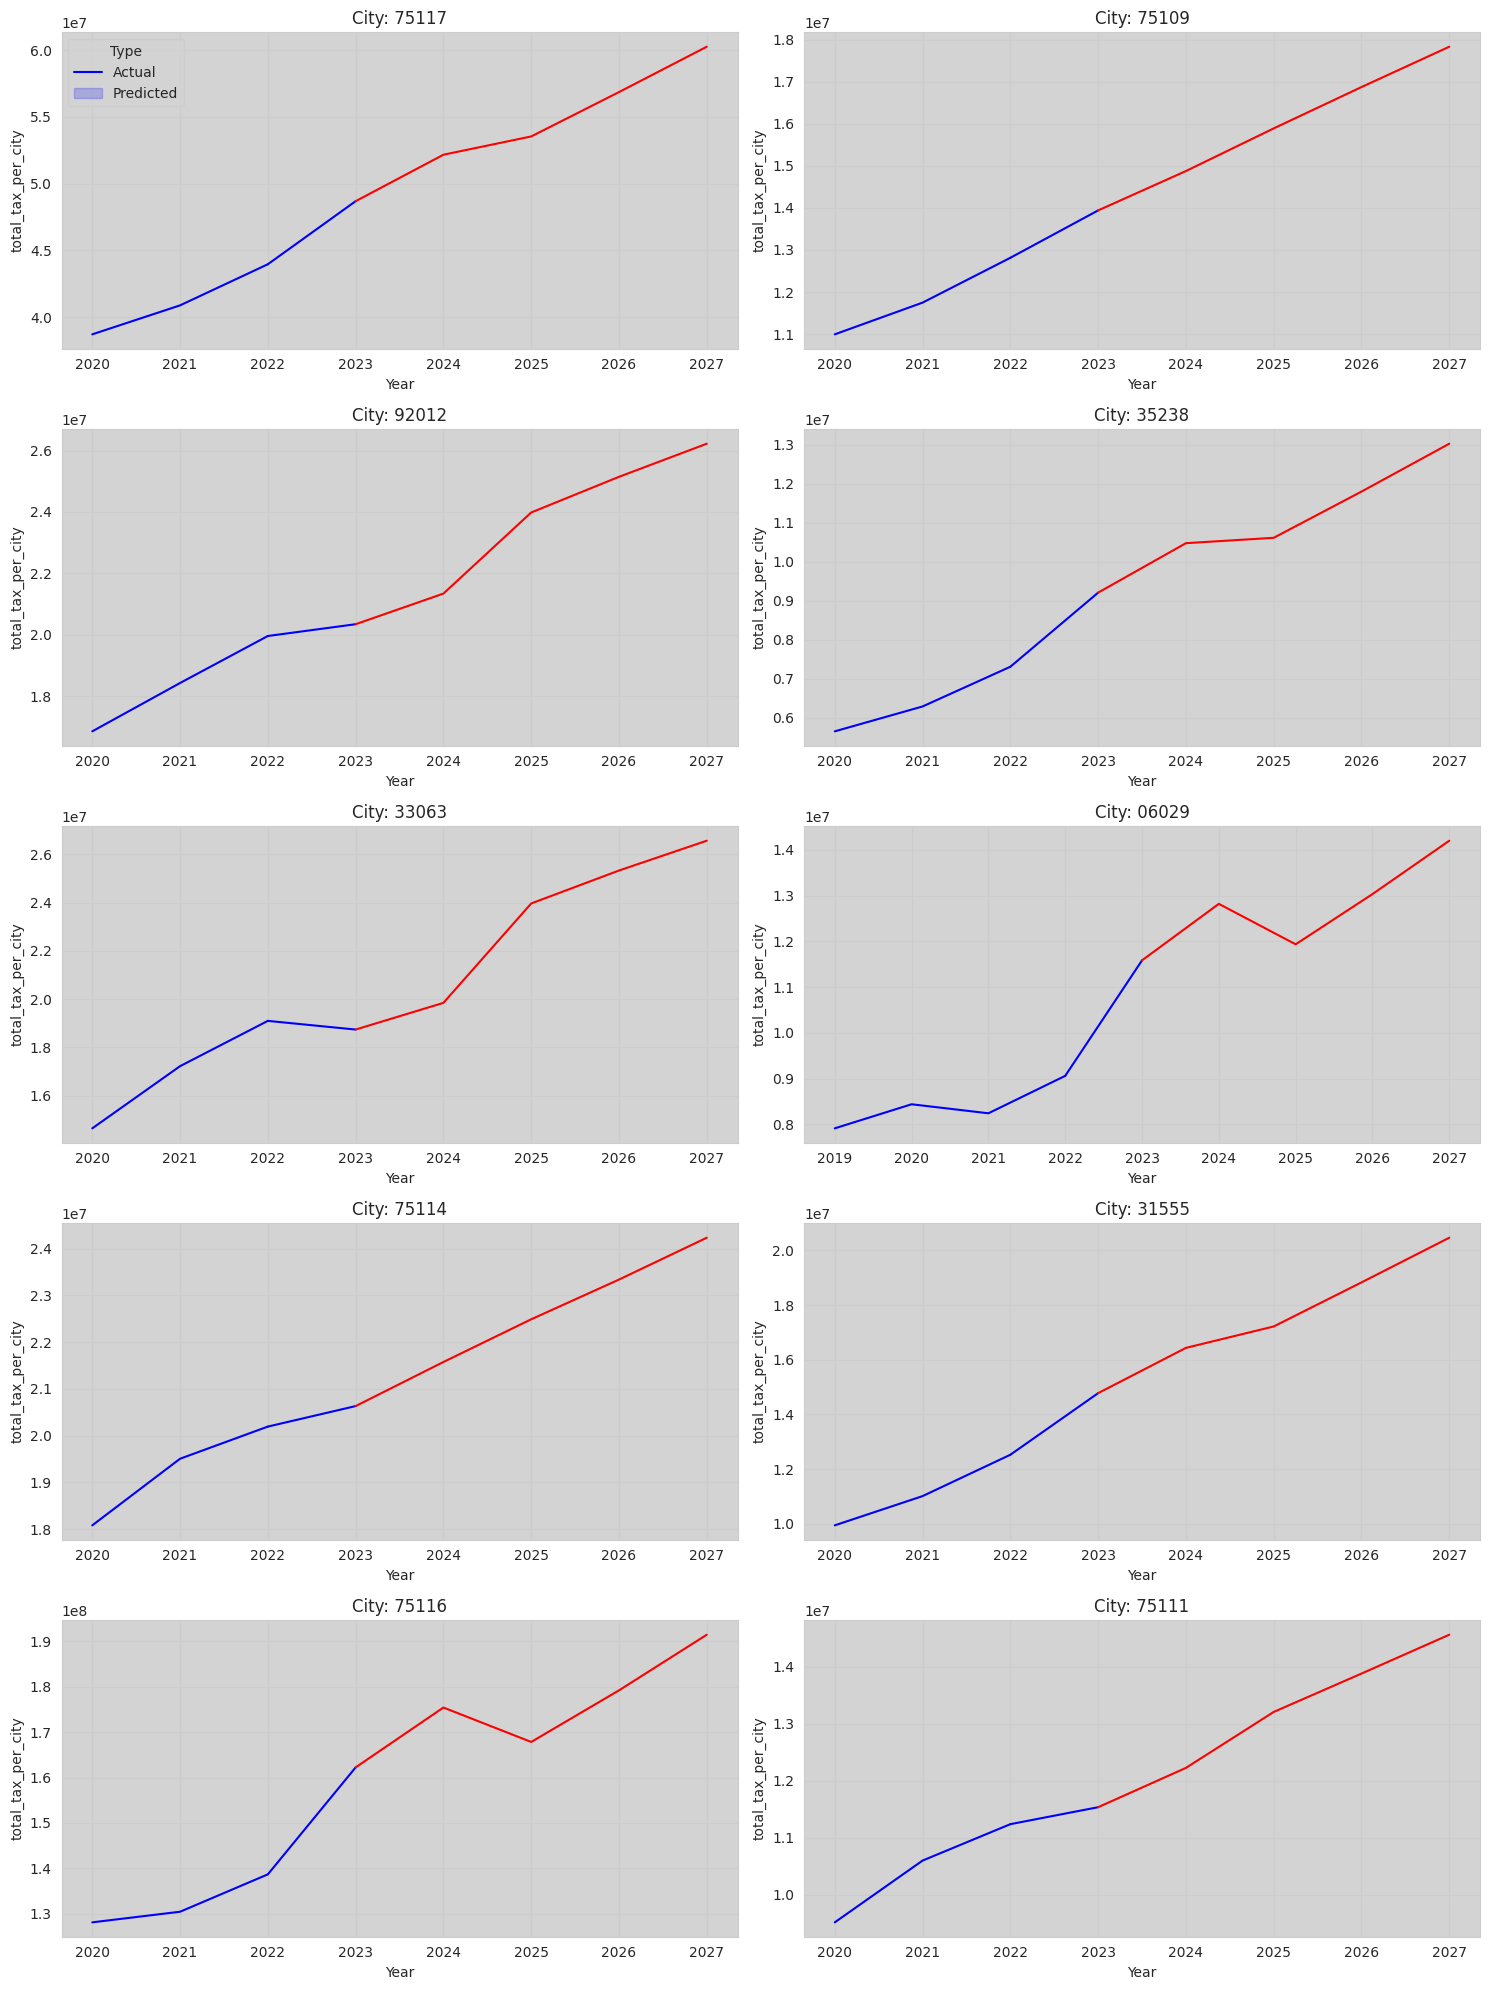

In [14]:
"""
This script visualizes prediction results using the Prophet method for cities that are identified as outliers.
The steps include extracting outlier cities, calculating their growth rates, selecting a random sample of 10 cities,
and plotting the actual vs predicted tax values over the years for these cities.
"""

# Copy predictions from unknown_data to df_ificom_clean_to_be_predictedV2
for index, row in unknown_data.iterrows():
    # Locate the matching row index in df_ificom_clean_to_be_predictedV2
    target_index = df_ificom_clean_to_be_predictedV2[
        (df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) &
        (df_ificom_clean_to_be_predictedV2['Year'] == row['Year'])
    ].index[0]

    # Update the columns in df_ificom_clean_to_be_predictedV2 using values from unknown_data
    for column in ['latitude', 'longitude', 'total_tax_per_city', 'total_tax_per_city_lag1',
                   'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest',
                   'to_be_predicted', 'predicted', 'Prophet']:
        df_ificom_clean_to_be_predictedV2.at[target_index, column] = row[column]


import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract outlier cities
outlier_df = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# 2. Calculate the growth rate for each outlier city
growth_rates = {}
for city in outlier_df['Commune_Code_INSEE'].drop_duplicates():
    city_data = outlier_df[outlier_df['Commune_Code_INSEE'] == city]
    initial_value = city_data['total_tax_per_city'].iloc[0]
    final_value = city_data['total_tax_per_city'].iloc[-1]

    growth_rate = (final_value - initial_value) / initial_value
    growth_rates[city] = growth_rate

# Convert growth rates to DataFrame
growth_rates_df = pd.DataFrame(list(growth_rates.items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# 3. Select 10 random outlier cities
random_10_cities = growth_rates_df['Commune_Code_INSEE'].sample(10).tolist()
selected_data = outlier_df[outlier_df['Commune_Code_INSEE'].isin(random_10_cities)].sort_values(by='Year')

# 4. Plot data for these cities
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
for idx, city in enumerate(random_10_cities):
    row = idx // 2
    col = idx % 2
    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city]

    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]

    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b')
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Type', labels=['Actual', 'Predicted'])

plt.tight_layout()
plt.show()


# Analyzing Prediction Outcomes

In this notebook, we delve into the results of our predictive modeling. We aim to visualize, study, and understand the outcomes, gauging the accuracy and pinpointing potential areas for model enhancement. This analysis will serve as a foundation for refining our approach and making more informed decisions in future iterations.

In [15]:
# 0. Filter out outlier cities
df_filtered = df_ificom_clean_to_be_predictedV2[~df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# Identify cities that lack data specifically for the years 2020, 2021, and 2022
years_to_check = [2020, 2021, 2022]
cities_to_exclude = [city for city in df_filtered['Commune_Code_INSEE'].unique()
                     if not all(year in df_filtered[df_filtered['Commune_Code_INSEE'] == city]['Year'].values for year in years_to_check)]

# Remove all rows corresponding to the identified cities
df_filtered = df_filtered[~df_filtered['Commune_Code_INSEE'].isin(cities_to_exclude)]

# Filter only for the years between 2022 and 2027 for growth rate calculation
df_filtered_2022_2027 = df_filtered[(df_filtered['Year'] >= 2022) & (df_filtered['Year'] <= 2027)]

# 1. Sort by city and year, then calculate the annual growth rate
df_sorted = df_filtered_2022_2027.sort_values(by=['Commune_Code_INSEE', 'Year'])
df_sorted['Yearly_Growth'] = df_sorted.groupby('Commune_Code_INSEE')['total_tax_per_city'].pct_change() * 100

# 2. Calculate the average annual growth rate for each city
average_growth_rates = df_sorted.groupby('Commune_Code_INSEE')['Yearly_Growth'].mean().reset_index()

# 3. Sort cities by their average annual growth rate
average_growth_rates = average_growth_rates.sort_values(by='Yearly_Growth', ascending=False)

# 4. Select the top 5 and bottom 5 cities based on average annual growth rate
top_5_cities = average_growth_rates.head(5)
bottom_5_cities = average_growth_rates.tail(5)

# Filter the DataFrame for the year 2022
df_2022 = df_ificom_clean_to_be_predictedV2.query('Year == 2022')

# Select columns of interest
columns_of_interest = ['Region', 'Department', 'Commune_Code_INSEE', 'City']
df_abstraction = df_2022[columns_of_interest]

# Remove duplicates (in case there's more than one entry for a given Commune_Code_INSEE in 2022)
df_abstraction = df_abstraction.drop_duplicates()

average_growth_rates=df_abstraction.merge(average_growth_rates, how='left',left_on='Commune_Code_INSEE',right_on='Commune_Code_INSEE').dropna()

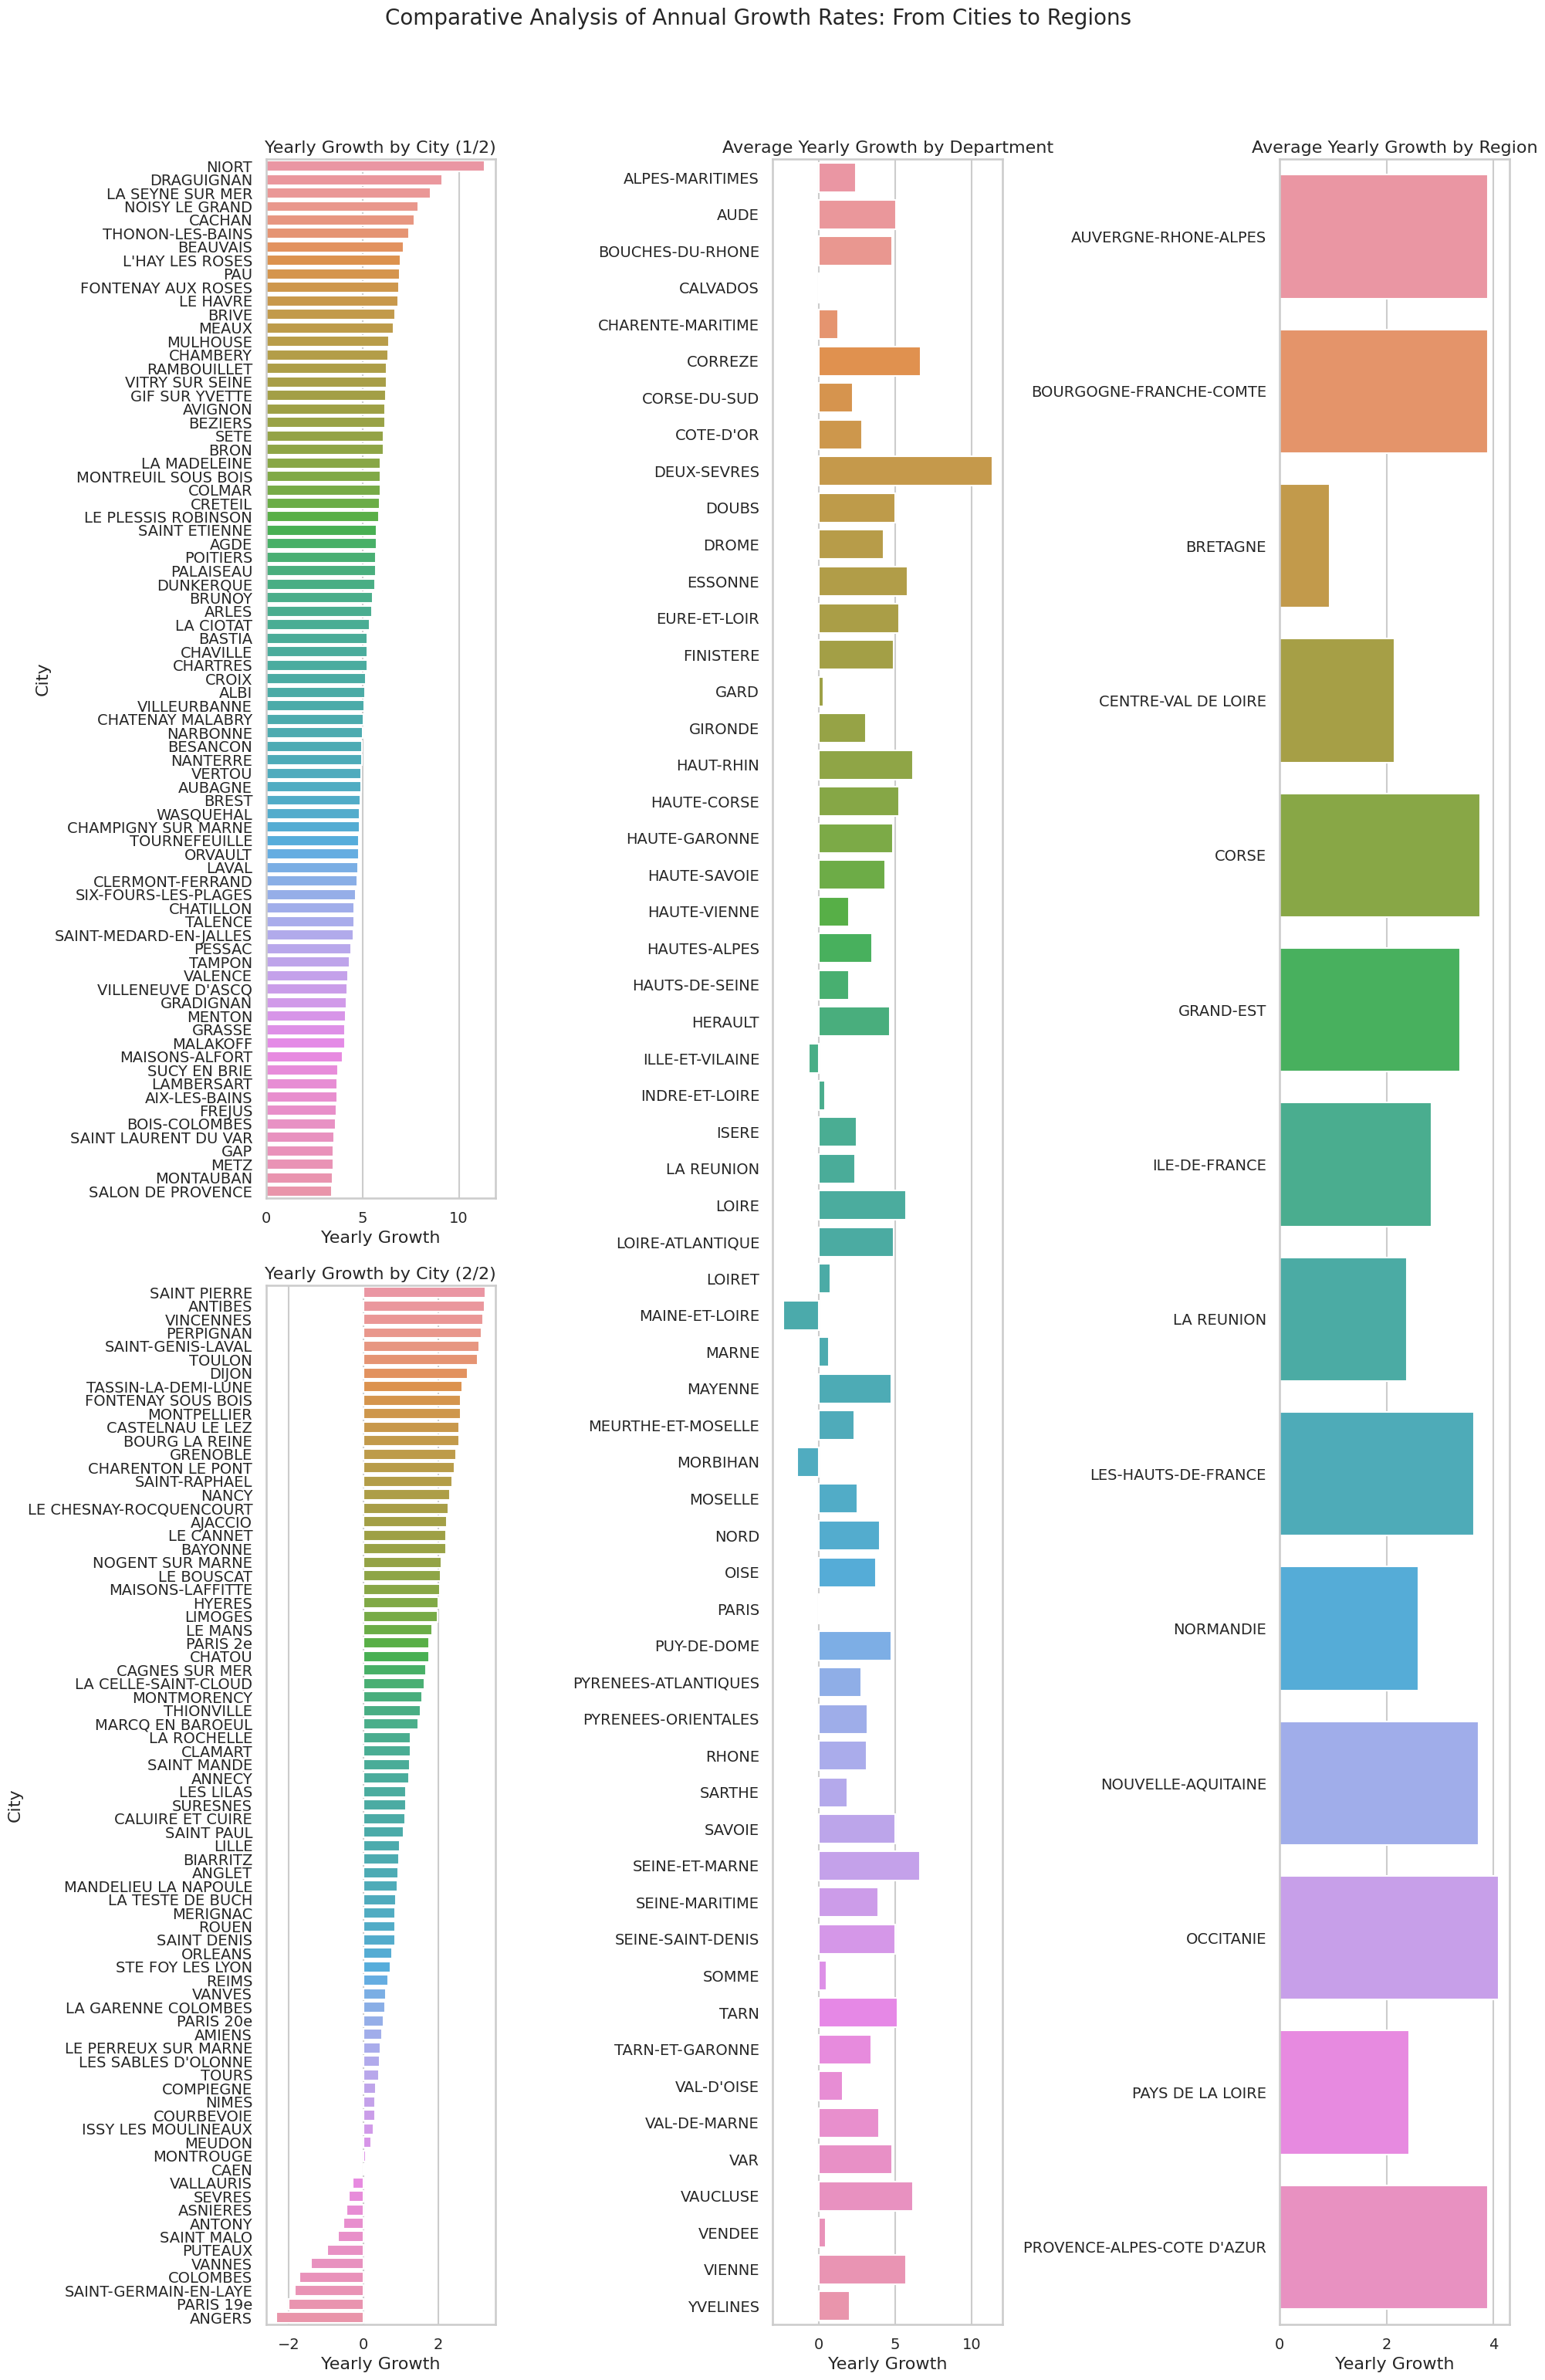

In [16]:
"""
This visualization showcases the annual growth rates of various cities, departments, and regions.
It provides a detailed horizontal bar chart representation, split into two parts for cities due to the large number of data points.
Additionally, it averages the growth rates at the department and region levels to provide insights into broader trends.
"""

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up Seaborn configurations for better visibility
sns.set_theme(style="whitegrid", context="talk", palette="viridis")

# Sort cities by Yearly Growth
sorted_cities = average_growth_rates.sort_values('Yearly_Growth', ascending=False)

# Split the dataset of cities into two
middle_idx = len(sorted_cities) // 2
first_half_cities = sorted_cities.iloc[:middle_idx]
second_half_cities = sorted_cities.iloc[middle_idx:]

# Create a main figure
plt.figure(figsize=(20, 30))

# Title for the entire figure
plt.suptitle("Comparative Analysis of Annual Growth Rates: From Cities to Regions", fontsize=20, y=1.03)

# Horizontal bar chart to display "Yearly Growth" by city (first half)
plt.subplot(2, 3, 1)
sns.barplot(y='City', x='Yearly_Growth', data=first_half_cities)
plt.title('Yearly Growth by City (1/2)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('City', fontsize=16)
plt.xlabel('Yearly Growth', fontsize=16)

# Horizontal bar chart to display "Yearly Growth" by city (second half)
plt.subplot(2, 3, 4)
sns.barplot(y='City', x='Yearly_Growth', data=second_half_cities)
plt.title('Yearly Growth by City (2/2)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('City', fontsize=16)
plt.xlabel('Yearly Growth', fontsize=16)

# Calculate averages by Department and Region
average_growth_by_department = average_growth_rates.groupby('Department').mean(numeric_only=True).reset_index()
average_growth_by_region = average_growth_rates.groupby('Region').mean(numeric_only=True).reset_index()

# Horizontal bar chart to display average "Yearly Growth" by department
plt.subplot(1, 3, 2)
sns.barplot(y='Department', x='Yearly_Growth', data=average_growth_by_department, estimator=np.mean, errorbar=None)
plt.title('Average Yearly Growth by Department', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Yearly Growth', fontsize=16)

# Horizontal bar chart to display average "Yearly Growth" by region
plt.subplot(1, 3, 3)
sns.barplot(y='Region', x='Yearly_Growth', data=average_growth_by_region, estimator=np.mean, errorbar=None)
plt.title('Average Yearly Growth by Region', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Yearly Growth', fontsize=16)

plt.tight_layout()
plt.show()


In [17]:
"""
Analysis:

- Cities:
  - Growth varies widely, from -2 to 10.
  - 'SALON DE PROVENCE' and 'ANGERS' are high-growth outliers, indicative of strong economic or developmental vigor.
  - In contrast, cities such as 'SAINT-GERMAIN-EN-LAYE' display negative growth, hinting at potential challenges or stagnation.

- Departments:
  - Growth ranges between -1 to 5.
  - 'HAUTES-ALPES' and 'GIRONDE' register significant growth, potentially earmarking them as investment hubs.
  - 'VENDÉE' is on the downturn, a point of concern for regional stakeholders.

- Regions:
  - All regions witness positive growth, peaking at 4.
  - 'PROVENCE-ALPES-CÔTE D'AZUR' and 'PAYS DE LA LOIRE' lead the pack, signaling regional prosperity or efficient initiatives.

Insights:
- Majority areas trend towards positive growth, but there's pronounced disparity among cities within identical departments or regions.
- High-growth zones might be riding on the back of propitious policies, tourism influx, or industrial upsurges.
- Uniformly positive growth at the regional level denotes widespread success; however, city-level disparities unmask localized challenges or boons.
- Negative growth precincts might necessitate targeted interventions or a deeper dive to unearth root causes.
"""


"\nAnalysis:\n\n- Cities:\n  - Growth varies widely, from -2 to 10.\n  - 'SALON DE PROVENCE' and 'ANGERS' are high-growth outliers, indicative of strong economic or developmental vigor.\n  - In contrast, cities such as 'SAINT-GERMAIN-EN-LAYE' display negative growth, hinting at potential challenges or stagnation.\n\n- Departments:\n  - Growth ranges between -1 to 5.\n  - 'HAUTES-ALPES' and 'GIRONDE' register significant growth, potentially earmarking them as investment hubs.\n  - 'VENDÉE' is on the downturn, a point of concern for regional stakeholders.\n\n- Regions:\n  - All regions witness positive growth, peaking at 4.\n  - 'PROVENCE-ALPES-CÔTE D'AZUR' and 'PAYS DE LA LOIRE' lead the pack, signaling regional prosperity or efficient initiatives.\n\nInsights:\n- Majority areas trend towards positive growth, but there's pronounced disparity among cities within identical departments or regions.\n- High-growth zones might be riding on the back of propitious policies, tourism influx, or i

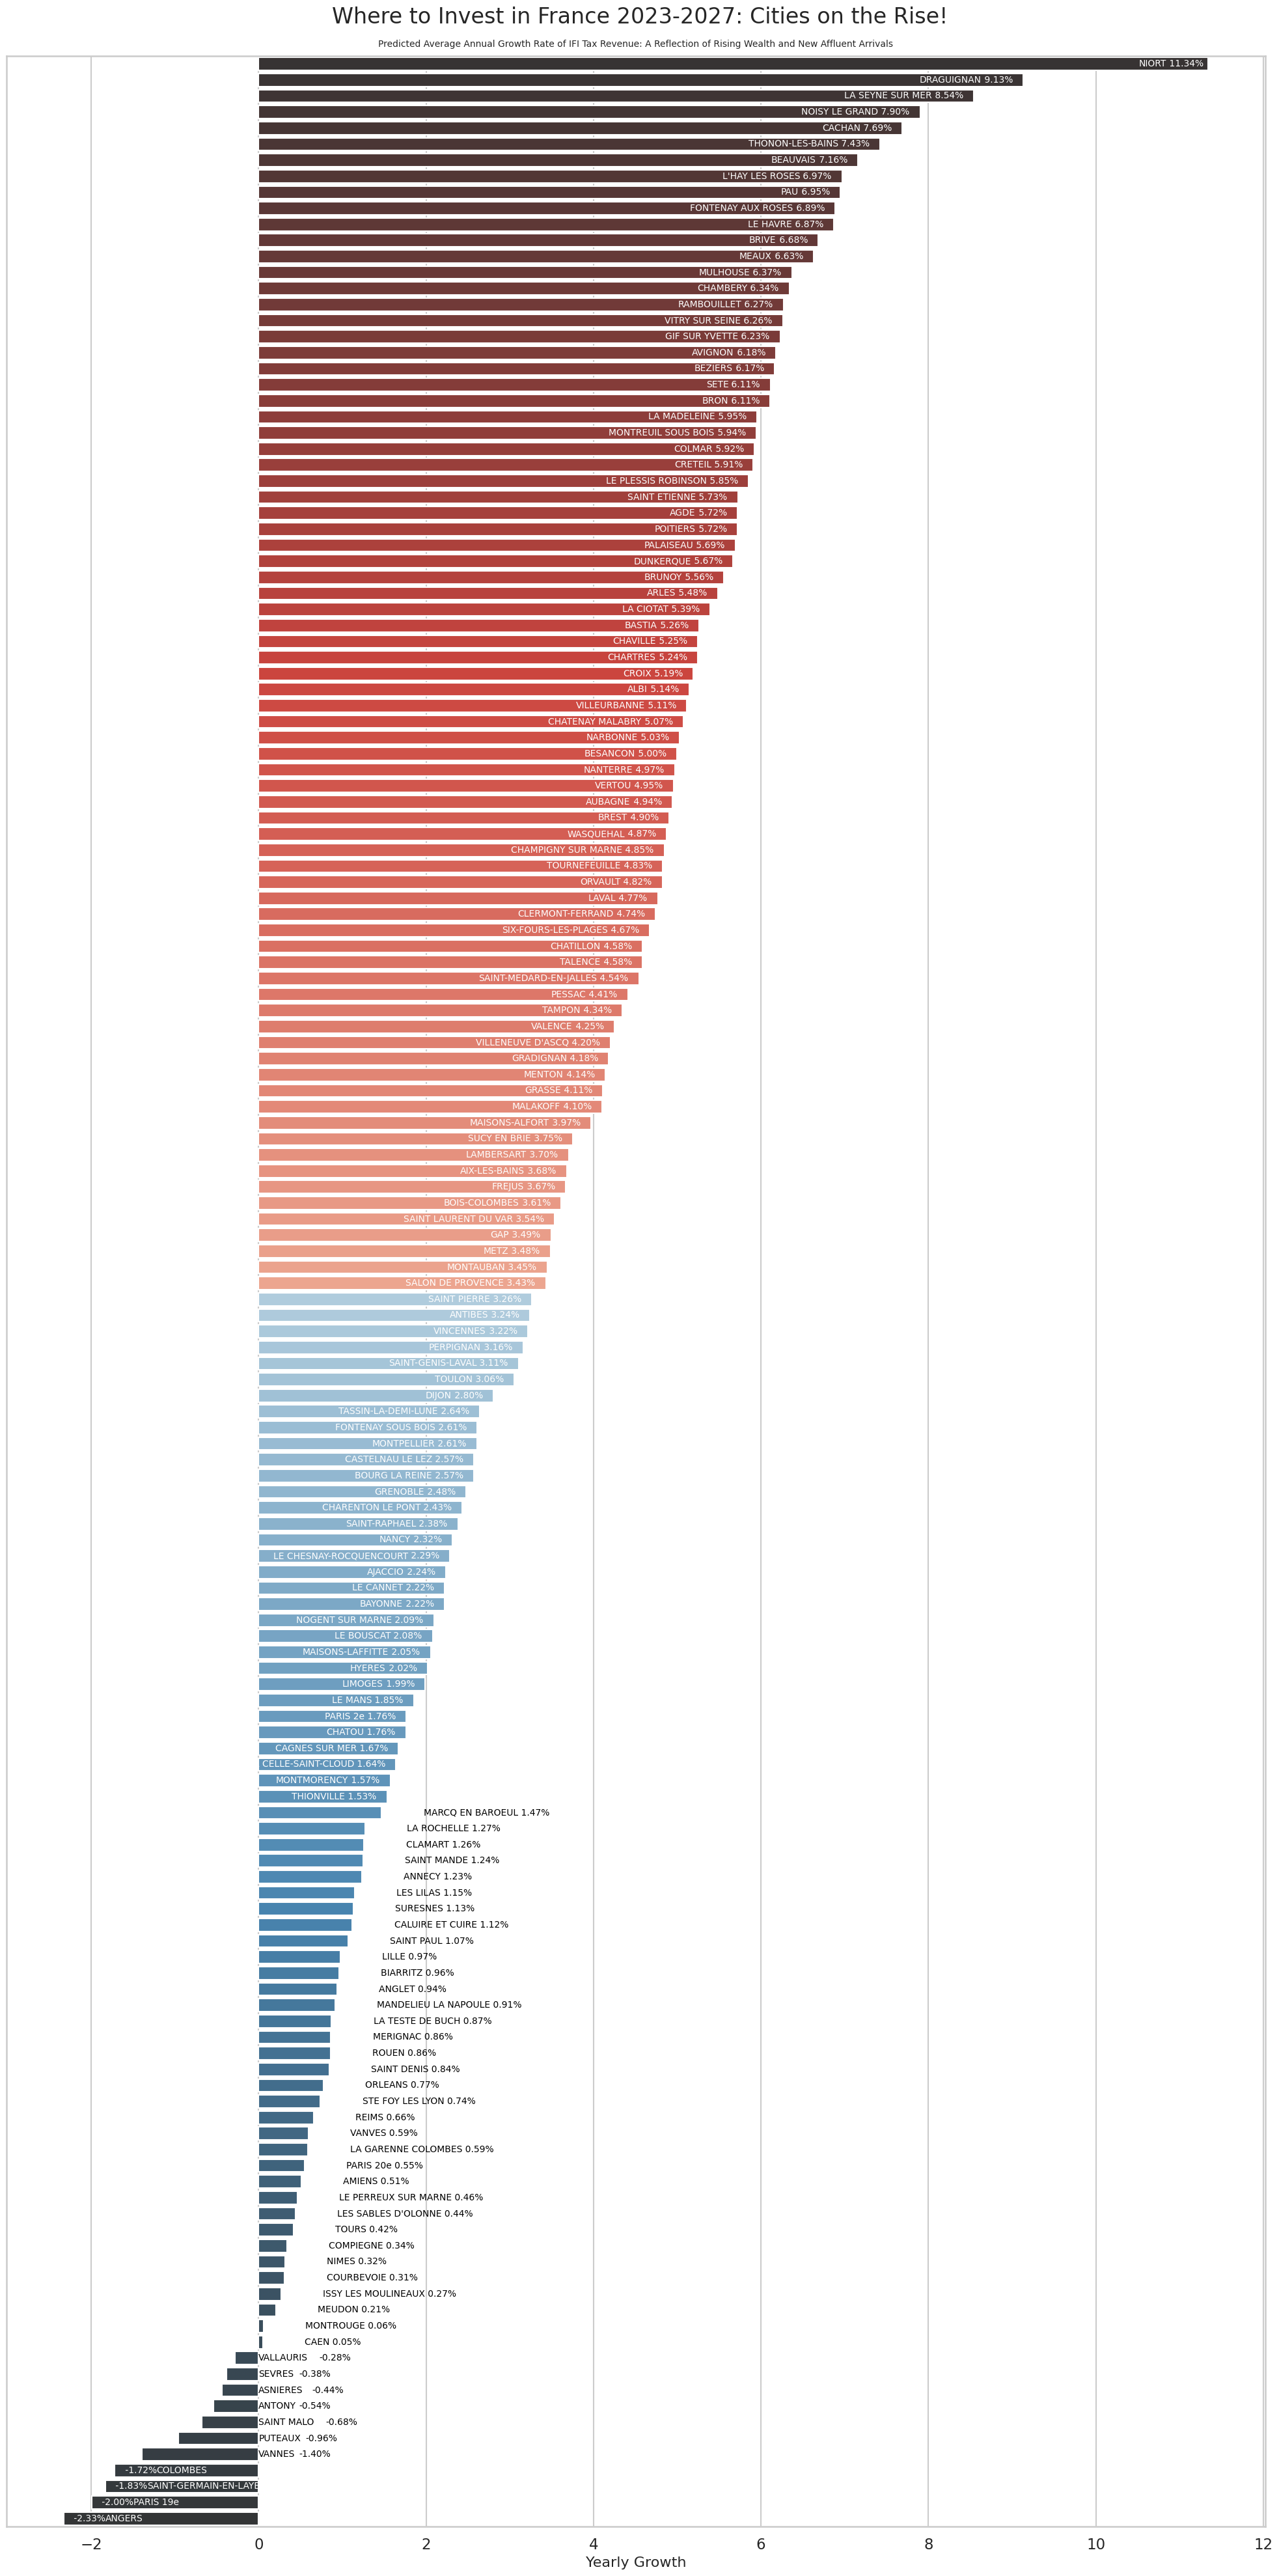

In [18]:
"""
This script visualizes the predicted average annual growth rates of IFI tax revenue for various cities.
The growth rates serve as a reflection of rising wealth and the influx of affluent individuals.
Cities are sorted based on their growth rates, and the visualization is presented using horizontal bars.
Each city and its corresponding growth rate is annotated on the plot.
"""

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seaborn setup for better visibility
sns.set_theme(style="whitegrid", context="talk")

# Sort cities based on Yearly Growth
sorted_cities = average_growth_rates.sort_values('Yearly_Growth', ascending=False)

# Create the main figure
fig, ax1 = plt.subplots(figsize=(20, 40))

# Build modern, dark color palettes
blue_palette = sns.color_palette("Blues_d", len(sorted_cities) // 2)
red_palette = sns.color_palette("Reds_d", len(sorted_cities) // 2)[::-1]
colors = red_palette + blue_palette

# Horizontal bar plot for "Yearly Growth" by city without Y-axis labels
sns.barplot(y='City', x='Yearly_Growth', data=sorted_cities, ax=ax1, palette=colors)
ax1.set_yticklabels([])  # Remove Y-axis labels

# Annotate city name and growth
for i in range(len(sorted_cities)):
    value, name = sorted_cities['Yearly_Growth'].iloc[i], sorted_cities['City'].iloc[i]
    if value > 1.53 or value < -1.4:
        alignment = 'right' if value >= 0 else 'left'
        ax1.text(value - 0.5 if value >= 0 else value + 0.5, i, name, va='center', fontsize=10, color='white', ha=alignment)
        ax1.text(value - 0.5 if value >= 0 else value + 0.5, i, f' {value:,.2f}%', va='center', fontsize=10, color='white', ha=('left' if value >= 0 else 'right'))
    elif -1.4 < value < -0.28:  # Cities between -0.28% and -1.4%
        ax1.text(0, i, f'{name}', va='center', fontsize=10, color='black', ha='left')
        ax1.text(0 + len(name)*0.08, i, f'{value:,.2f}%', va='center', fontsize=10, color='black', ha='left')
    else:
        alignment = 'left' if value >= 0 else 'right'
        ax1.text(value + 0.5 if value >= 0 else value - 0.5, i, f'{name} {value:,.2f}%', va='center', fontsize=10, color='black', ha=alignment)

# Set titles for the plot and axes
fig.suptitle('Where to Invest in France 2023-2027: Cities on the Rise!', fontsize=24, y=.991)
ax1.set_title('Predicted Average Annual Growth Rate of IFI Tax Revenue: A Reflection of Rising Wealth and New Affluent Arrivals',
              fontsize=10, pad=10)
ax1.set_ylabel('')  # Remove Y-axis label
ax1.set_xlabel('Yearly Growth', fontsize=16)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [19]:
'''
Analysis of "Where to Invest in France 2023-2027: Cities on the Rise!"

This bar chart provides insights into the predicted average annual growth rate of various cities in France for the period 2023-2027. The rate of growth is likely a reflection of rising wealth and new affluent arrivals in these cities.

Key Takeaways:

The cities at the top of the chart (in red) show the highest predicted growth rates. Notably, "NIORT" and "DRAGUIGNAN" are leading with growth rates surpassing 9%.
Cities in the middle (in orange) have moderate predicted growth rates, with values generally ranging between 5% and 8%.
Cities at the bottom (in blue) are experiencing slower growth or even a decline. Specifically, "NÎMES" shows a negative growth rate of approximately -4%, indicating a potential decrease in wealth or affluent arrivals.

In conclusion, if someone is considering investment opportunities based on these growth rates, the cities in the red and orange zones could be prioritized, while being cautious about those in the blue zone.
'''

'\nAnalysis of "Where to Invest in France 2023-2027: Cities on the Rise!"\n\nThis bar chart provides insights into the predicted average annual growth rate of various cities in France for the period 2023-2027. The rate of growth is likely a reflection of rising wealth and new affluent arrivals in these cities.\n\nKey Takeaways:\n\nThe cities at the top of the chart (in red) show the highest predicted growth rates. Notably, "NIORT" and "DRAGUIGNAN" are leading with growth rates surpassing 9%.\nCities in the middle (in orange) have moderate predicted growth rates, with values generally ranging between 5% and 8%.\nCities at the bottom (in blue) are experiencing slower growth or even a decline. Specifically, "NÎMES" shows a negative growth rate of approximately -4%, indicating a potential decrease in wealth or affluent arrivals.\n\nIn conclusion, if someone is considering investment opportunities based on these growth rates, the cities in the red and orange zones could be prioritized, whil

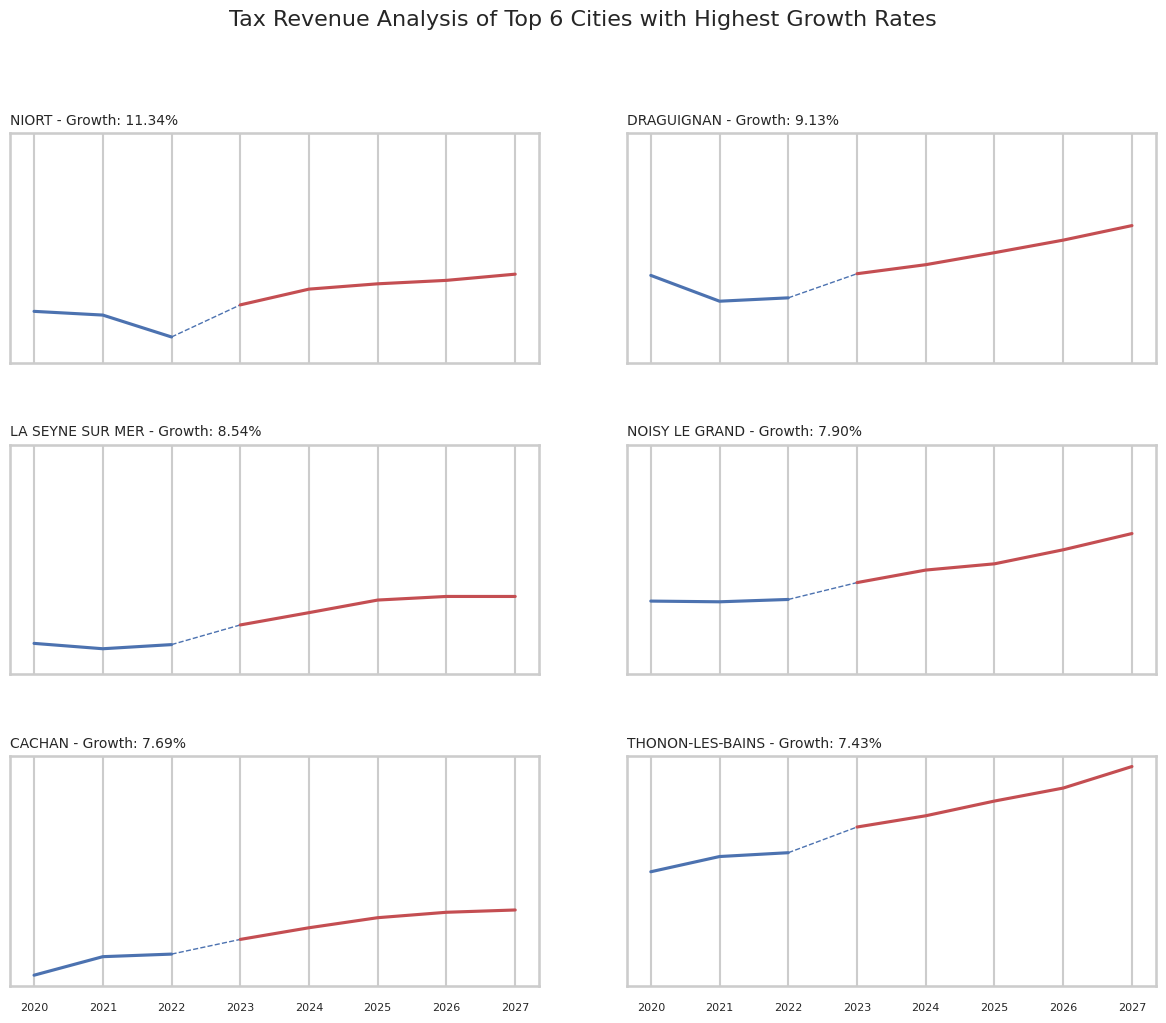

In [20]:
"""
This script visualizes the tax revenue for the top six cities with the highest annual growth rates.
For each city, actual and predicted tax revenues over the years are plotted side by side.
The blue line represents the actual tax revenue, while the red line represents the predictions.
The cities are organized in subplots, with each subplot titled with the city's name and its growth rate.
"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seaborn style
sns.set_style("whitegrid")

# 1. Select the top 6 cities with the highest annual growth
top_6_cities = average_growth_rates.sort_values(by="Yearly_Growth", ascending=False).head(6)['Commune_Code_INSEE'].tolist()

# 2. Extract data for these cities
selected_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(top_6_cities)]

# 3. Plot data for these cities
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=True, sharey=True)

# Add a coherent title for the entire plot
fig.suptitle('Tax Revenue Analysis of Top 6 Cities with Highest Growth Rates', fontsize=16, y=1.03)

for idx, city_code in enumerate(top_6_cities):
    row = idx // 2
    col = idx % 2

    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city_code]
    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]
    city_name = city_data['City'].iloc[0]

    # Plot actual data
    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)
    # Dashed line to connect actual and predicted data
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b', linestyle='--', linewidth=1)
    # Plot predicted data
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    # Set title with growth rate
    growth_rate = average_growth_rates[average_growth_rates['Commune_Code_INSEE'] == city_code]['Yearly_Growth'].values[0]
    axes[row, col].set_title(f'{city_name} - Growth: {growth_rate:.2f}%', loc='left', fontsize=10)

    # Remove Y-axis labels and ticks
    axes[row, col].set_ylabel('')
    axes[row, col].set_xlabel('')  # Remove "Year" label
    axes[row, col].yaxis.set_ticks([])
    # Adjust Y-axis format to avoid scientific notation
    axes[row, col].get_yaxis().get_major_formatter().set_useOffset(False)

    # Configure font size for the axes
    axes[row, col].tick_params(axis='both', which='major', labelsize=8)

# Avoid creating a centralized legend
# handles, labels = axes[0,0].get_legend_handles_labels()
# fig.legend(handles, ['Real', 'Predicted'], title='Type', title_fontsize='10', loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize='8')

plt.tight_layout(h_pad=2.5, w_pad=3.5)
plt.show()

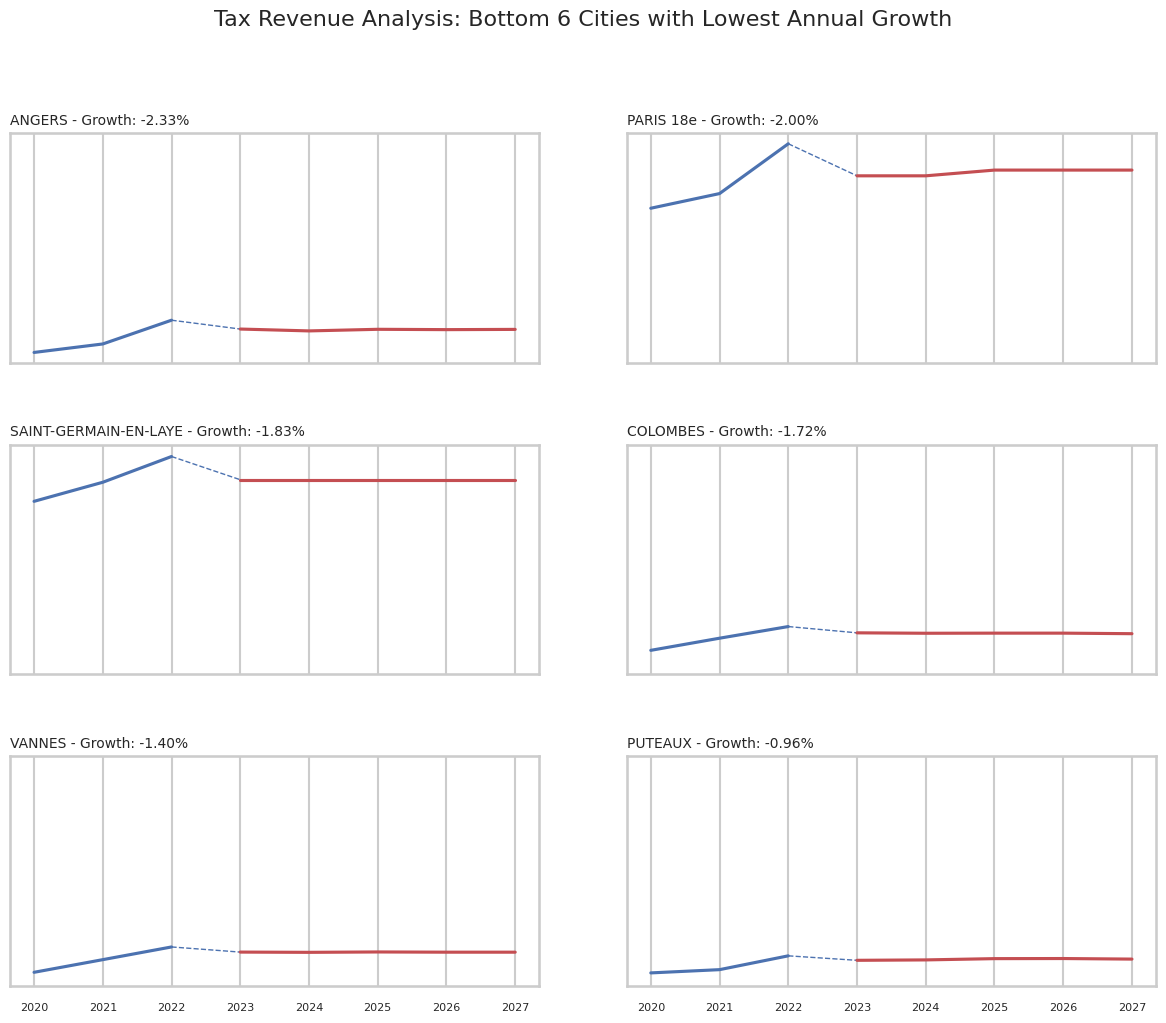

In [21]:
"""
This script visualizes the tax revenue for the six cities with the lowest annual growth rates.
Each city's data is plotted in a subplot, showing actual tax revenues (in blue) and predicted tax revenues (in red) over the years.
The dashed line connects the last actual data point with the first predicted data point for each city.
Each subplot is titled with the city's name and its growth rate.
"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seaborn style
sns.set_style("whitegrid")

# 1. Select the bottom 6 cities with the lowest annual growth
bottom_6_cities = average_growth_rates.sort_values(by="Yearly_Growth", ascending=True).head(6)['Commune_Code_INSEE'].tolist()

# 2. Extract data for these cities
selected_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(bottom_6_cities)]

# 3. Plot data for these cities
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=True, sharey=True)

# Add a coherent title for the entire plot
fig.suptitle('Tax Revenue Analysis: Bottom 6 Cities with Lowest Annual Growth', fontsize=16, y=1.03)

for idx, city_code in enumerate(bottom_6_cities):
    row = idx // 2
    col = idx % 2

    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city_code]
    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]
    city_name = city_data['City'].iloc[0]

    # Plot actual data
    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)
    # Dashed line to connect actual and predicted data
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b', linestyle='--', linewidth=1)
    # Plot predicted data
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    # Set title with growth rate
    growth_rate = average_growth_rates[average_growth_rates['Commune_Code_INSEE'] == city_code]['Yearly_Growth'].values[0]
    axes[row, col].set_title(f'{city_name} - Growth: {growth_rate:.2f}%', loc='left', fontsize=10)

    # Remove Y-axis labels and ticks
    axes[row, col].set_ylabel('')
    axes[row, col].set_xlabel('')  # Removing the "Year" label
    axes[row, col].yaxis.set_ticks([])
    # Adjust Y-axis format to avoid scientific notation
    axes[row, col].get_yaxis().get_major_formatter().set_useOffset(False)

    # Configure font size for the axes
    axes[row, col].tick_params(axis='both', which='major', labelsize=8)

# Avoid creating a centralized legend
# handles, labels = axes[0,0].get_legend_handles_labels()
# fig.legend(handles, ['Real', 'Predicted'], title='Type', title_fontsize='10', loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize='8')

plt.tight_layout(h_pad=2.5, w_pad=3.5)
plt.show()


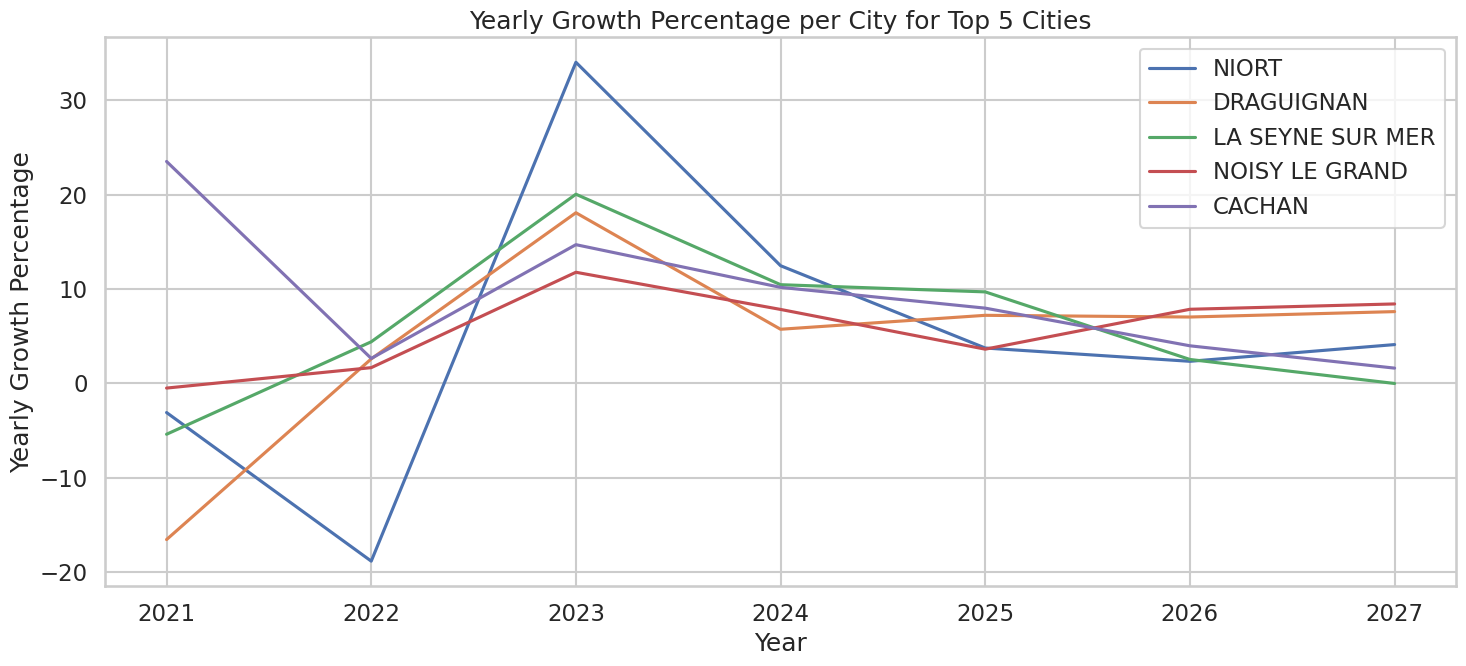

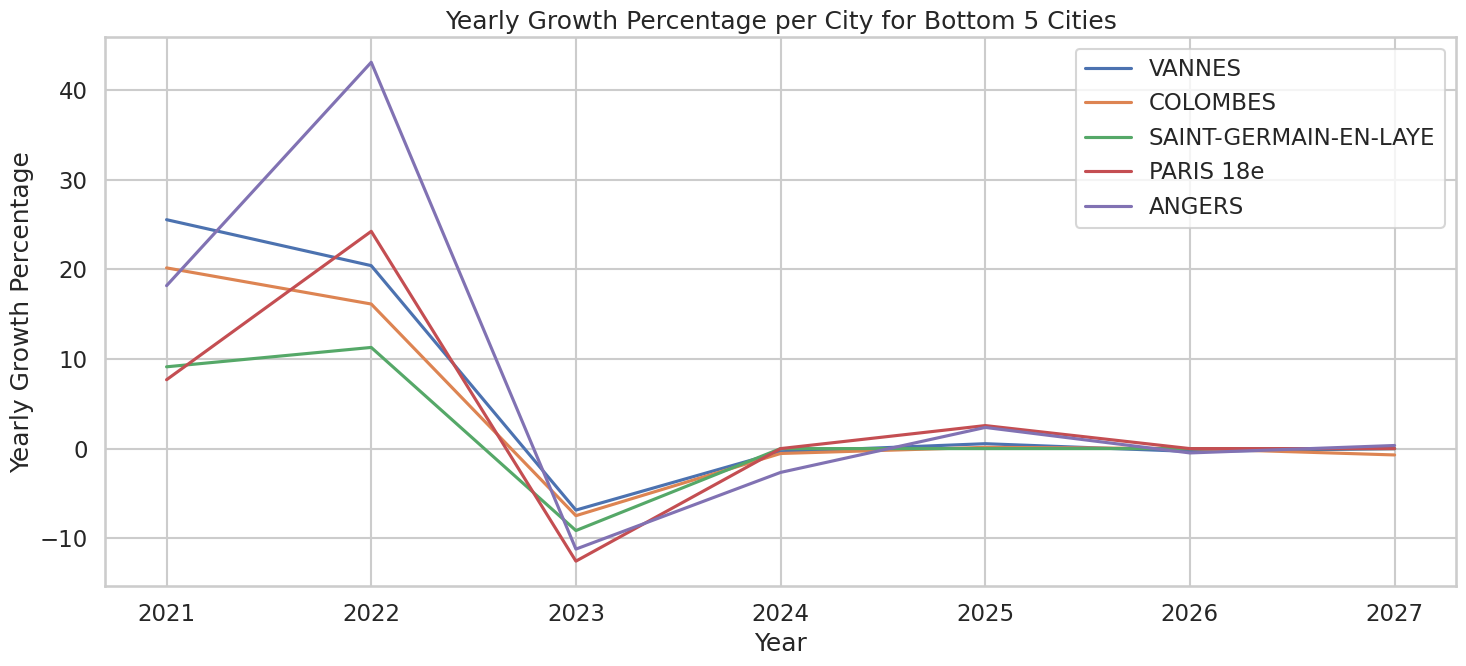

In [22]:
"""
This script processes and visualizes the yearly growth percentage of tax revenues for selected cities.
The growth percentage is calculated based on the current year's tax revenue compared to the previous year's tax revenue.
Two separate plots are generated:
- The first plot showcases the top 5 cities with the highest growth.
- The second plot highlights the bottom 5 cities with the lowest growth.
For each city, the growth percentage over the years is plotted.
"""

import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'Year' column to int
df_ificom_clean_to_be_predictedV2['Year'] = df_ificom_clean_to_be_predictedV2['Year'].astype(int)

# Sort the DataFrame by 'Commune_Code_INSEE' and 'Year'
df_ificom_clean_to_be_predictedV2 = df_ificom_clean_to_be_predictedV2.sort_values(by=['Commune_Code_INSEE', 'Year'])

# Get the value of the previous year
df_ificom_clean_to_be_predictedV2['total_tax_per_city_lag1'] = df_ificom_clean_to_be_predictedV2.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)

# Calculate the year-on-year growth rate
df_ificom_clean_to_be_predictedV2['growth_percentage'] = ((df_ificom_clean_to_be_predictedV2['total_tax_per_city'] / df_ificom_clean_to_be_predictedV2['total_tax_per_city_lag1']) - 1) * 100

# ---- Plot for cities with the highest growth ----

# Filter the DataFrame to only include selected top_5 cities
df_selected_top = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(top_5_cities['Commune_Code_INSEE'])]

plt.figure(figsize=(15, 7))
for city_code in top_5_cities['Commune_Code_INSEE']:
    city_data = df_selected_top[df_selected_top['Commune_Code_INSEE'] == city_code]
    city_name = city_data['City'].iloc[0]
    plt.plot(city_data['Year'], city_data['growth_percentage'], label=city_name)

plt.title('Yearly Growth Percentage per City for Top 5 Cities')
plt.xlabel('Year')
plt.ylabel('Yearly Growth Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot for cities with the lowest growth ----

# Filter the DataFrame to only include selected bottom_5 cities
df_selected_bottom = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(bottom_5_cities['Commune_Code_INSEE'])]

plt.figure(figsize=(15, 7))
for city_code in bottom_5_cities['Commune_Code_INSEE']:
    city_data = df_selected_bottom[df_selected_bottom['Commune_Code_INSEE'] == city_code]
    city_name = city_data['City'].iloc[0]
    plt.plot(city_data['Year'], city_data['growth_percentage'], label=city_name)

plt.title('Yearly Growth Percentage per City for Bottom 5 Cities')
plt.xlabel('Year')
plt.ylabel('Yearly Growth Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
'''
# Análisis de Crecimiento Anual por Ciudad

## Ciudades con Menor Crecimiento

- **VANNES** mostró un pico de crecimiento en 2023, pero luego ha mantenido un crecimiento relativamente estable.
- **COLOMBES** y **SAINT-GERMAIN-EN-LAYE** presentaron un crecimiento similar, con un descenso en 2023 seguido de una recuperación en años subsiguientes.
- **PARIS 18e** tuvo una caída significativa en 2023, pero ha logrado mantenerse estable desde entonces.
- **ANGERS** ha mantenido una tasa de crecimiento constante a lo largo de los años.

## Ciudades con Mayor Crecimiento

- **NIORT** experimentó un descenso notable en 2022, pero se recuperó rápidamente en 2023. Sin embargo, después de 2023, el crecimiento ha sido decreciente.
- **DRAGUIGNAN** y **LA SEYNE SUR MER** tuvieron un patrón de crecimiento similar, con un pico en 2023.
- **NOISY LE GRAND** presentó una disminución en 2022, seguido de un aumento en 2023 y luego una tendencia decreciente.
- **CACHAN** ha tenido una tendencia de crecimiento más estable en comparación con las otras ciudades, sin grandes picos o caídas.

## Conclusión

El año 2023 parece ser un punto de inflexión para muchas de estas ciudades, ya que muchas de ellas experimentaron picos o descensos en el crecimiento. Sería útil investigar eventos o políticas específicas de ese año que podrían haber influido en estas tendencias.
'''


'\n# Análisis de Crecimiento Anual por Ciudad\n\n## Ciudades con Menor Crecimiento\n\n- **VANNES** mostró un pico de crecimiento en 2023, pero luego ha mantenido un crecimiento relativamente estable.\n- **COLOMBES** y **SAINT-GERMAIN-EN-LAYE** presentaron un crecimiento similar, con un descenso en 2023 seguido de una recuperación en años subsiguientes.\n- **PARIS 18e** tuvo una caída significativa en 2023, pero ha logrado mantenerse estable desde entonces.\n- **ANGERS** ha mantenido una tasa de crecimiento constante a lo largo de los años.\n\n## Ciudades con Mayor Crecimiento\n\n- **NIORT** experimentó un descenso notable en 2022, pero se recuperó rápidamente en 2023. Sin embargo, después de 2023, el crecimiento ha sido decreciente.\n- **DRAGUIGNAN** y **LA SEYNE SUR MER** tuvieron un patrón de crecimiento similar, con un pico en 2023.\n- **NOISY LE GRAND** presentó una disminución en 2022, seguido de un aumento en 2023 y luego una tendencia decreciente.\n- **CACHAN** ha tenido una ten

In [24]:
"""
This script visualizes the yearly growth rates of different cities in France.
The cities are represented on a map of France, and they are color-coded based on their growth rates:

- Green: Represents the top 10 cities with the highest yearly growth rates.
- Red: Represents the bottom 10 cities with the lowest yearly growth rates.
- Orange: Represents cities that fall in between the top and bottom 10.
- Gray: Represents cities for which there's no data available.

The map also includes a legend to help interpret the color codes.
"""

import folium
import pandas as pd
import geopandas as gpd

# Assuming you already have the df_ificom_clean_to_be_predictedV2 DataFrame loaded
df = df_ificom_clean_to_be_predictedV2.copy()

# Filter for the year 2020
df = df[df['Year'] == 2020.0]

# Exclude cities where Prophet is True
df = df[df['Prophet'] != True]

# Merge with average_growth_rates
df = pd.merge(df, average_growth_rates, on='Commune_Code_INSEE', how='left')

# Remove rows with NaN values in 'latitude' and 'longitude' columns
df = df.dropna(subset=['latitude', 'longitude'])

# Sort the DataFrame based on 'Yearly_Growth' and get threshold values for top 10 and bottom 10
df = df.dropna(subset=['Yearly_Growth'])
sorted_df = df.sort_values(by='Yearly_Growth')
top_10_threshold = sorted_df['Yearly_Growth'].iloc[-10]
flop_10_threshold = sorted_df['Yearly_Growth'].iloc[9]

# Function to determine the color of each city based on its growth rate
def get_color(value):
    if value >= top_10_threshold:
        return 'green'
    elif value <= flop_10_threshold:
        return 'red'
    else:
        return 'orange'

# Load GeoJSON data
PATH_IN_GEOJSON = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/Prediction_5Years_IFITAX/DataIn/'
geojson_data = gpd.read_file(PATH_IN_GEOJSON+'communes-avec-outre-mer.geojson')

# Simplify the GeoJSON data to reduce its size
simplified_geojson_data = geojson_data.copy()
simplified_geojson_data['geometry'] = simplified_geojson_data.geometry.simplify(tolerance=0.005)

# Calculate average Yearly_Growth for each Commune_Code_INSEE
average_growth_by_commune = df.groupby('Commune_Code_INSEE')['Yearly_Growth'].mean()

def get_region_color(commune_code):
    # Assuming average_growth_by_commune is a global series
    if commune_code in average_growth_by_commune:
        return get_color(average_growth_by_commune[commune_code])
    else:
        return 'gray'  # default color if no data is available

# Create a map centered on France
map_france = folium.Map(location=[46.603354, 1.888334], zoom_start=6, tiles="CartoDB positron")

folium.GeoJson(
    simplified_geojson_data,
    style_function=lambda feature: {
        'fillColor': get_region_color(feature['properties']['code']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }
).add_to(map_france)

# Add a legend to the map
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 90px; background-color: rgba(255, 255, 255, 0.7); border:2px solid grey; z-index:9999; font-size:14px; border-radius: 6px;">
&nbsp;<b>Legend</b><br>
&nbsp;<i class="fa fa-square fa-1x" style="color:green"></i>&nbsp;Top 10<br>
&nbsp;<i class="fa fa-square fa-1x" style="color:orange"></i>&nbsp;Middle<br>
&nbsp;<i class="fa fa-square fa-1x" style="color:red"></i>&nbsp;Bottom 10
</div>
"""
map_france.get_root().html.add_child(folium.Element(legend_html))


In [25]:
map_france


Output hidden; open in https://colab.research.google.com to view.

In [26]:
"""
This script creates a map visualization for the growth rates of different French cities in the year 2020 using Folium.
Each city is marked by a circle, where the color represents its growth category:
- Green for the top 10 cities with the highest growth rates.
- Red for the bottom 10 with the lowest growth rates.
- Orange for all other cities.

Cities where predictions are made with the Prophet model are excluded.
The map provides tooltips with city names and their respective yearly growth percentages.
"""

import folium
import pandas as pd
import branca

# Assuming df_ificom_clean_to_be_predictedV2 DataFrame is already loaded
df = df_ificom_clean_to_be_predictedV2.copy()

# Filter only for the year 2020
df = df[df['Year'] == 2020.0]

# Exclude cities where predictions are made using Prophet
df = df[df['Prophet'] != True]

# Merge with average_growth_rates
df = pd.merge(df, average_growth_rates[['Commune_Code_INSEE', 'City', 'Yearly_Growth']], on='Commune_Code_INSEE', how='left')

# Remove rows with NaN values in 'latitude', 'longitude', and 'Yearly_Growth' columns
df = df.dropna(subset=['latitude', 'longitude', 'Yearly_Growth'])

# Sort the DataFrame based on 'Yearly_Growth' and determine thresholds for the top 10 and bottom 10
sorted_df = df.sort_values(by='Yearly_Growth')
top_10_threshold = sorted_df['Yearly_Growth'].iloc[-10]
flop_10_threshold = sorted_df['Yearly_Growth'].iloc[9]

# Function to decide the color of each city based on its growth rate
def get_color(value):
    if value >= top_10_threshold:
        return 'green'
    elif value <= flop_10_threshold:
        return 'red'
    else:
        return 'orange'

# Create a map centered on France
map_france = folium.Map(location=[46.603354, 1.888334], zoom_start=6)  # Approximate coordinates of the center of France

# Add each city to the map
for index, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    color = get_color(row['Yearly_Growth'])
    city_name = row['City_x']  # Use the 'City' column here

    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.6,
        fill_color=color,
        tooltip=f"{city_name}: {row['Yearly_Growth']}%"
    ).add_to(map_france)

map_france


In [27]:
import folium
import pandas as pd
import numpy as np

# ... [rest of the previous code] ...

# Assuming df_ificom_clean_to_be_predictedV2 DataFrame is already loaded and prepared
df = df_ificom_clean_to_be_predictedV2.copy()

# Filter for the year 2020
df = df[df['Year'] == 2020.0]

# Exclude cities where predictions are made using Prophet
df = df[df['Prophet'] != True]

# Merge with average_growth_rates
df = pd.merge(df, average_growth_rates[['Commune_Code_INSEE', 'City', 'Yearly_Growth']], on='Commune_Code_INSEE', how='left')

# Remove rows with NaN values in 'latitude', 'longitude', and 'Yearly_Growth' columns
df = df.dropna(subset=['latitude', 'longitude', 'Yearly_Growth'])

# Determine thresholds for different ranges using percentiles
sorted_df = df.sort_values(by='Yearly_Growth')
percentiles = sorted_df['Yearly_Growth'].quantile([0.1, 0.3, 0.5, 0.7, 0.9])

# Function to decide the color of each city based on its percentile group
def get_color(value):
    if value >= percentiles[0.9]:
        return '#008000'  # green for top 10%
    elif value >= percentiles[0.7]:
        return '#ADFF2F'  # yellow-green for next 20%
    elif value >= percentiles[0.5]:
        return '#FFFF00'  # yellow for middle 20%
    elif value >= percentiles[0.3]:
        return '#FFA500'  # orange for next 20%
    else:
        return '#FF0000'  # red for bottom 10%

# Function to decide the radius of each city circle
def get_radius(value):
    return value * 200  # Adjust the factor 200 as needed

# Create a map centered on France with 'CartoDB dark_matter' style
map_france = folium.Map(location=[46.603354, 1.888334], zoom_start=6, tiles='CartoDB dark_matter')

# Add each city to the map
for index, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    color = get_color(row['Yearly_Growth'])
    radius = get_radius(row['Yearly_Growth'])
    folium.Circle(
        location=[lat, lon],
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.6,
        fill_color=color,
        tooltip=f"{row['City_x']}: {int(row['Yearly_Growth'] )}%"
    ).add_to(map_france)

# Display the map
map_france


# Cleaning data for Data Visualization
 This section of the code prepares the dataset for visualization by performing several data cleaning steps:


1.   Static Data Export:
The first export takes the static information from df_ificom_clean_to_be_predictedV2 and saves it to a CSV file named static_df.csv. This static information includes regional and local identifiers, geographic coordinates, and city names—data that doesn't change over time.

2.   Dynamic Data Export:
The second export involves data that is subject to change over time, such as the number of taxpayers, average assets, average tax, and various statistical measures. This information is more dynamic as it can vary from one report to another. It's saved in the df_ificom_generated_data.csv file.

3.  Calculated Data Export:
The third part saves the average_growth_rates, top_5_cities, and bottom_5_cities to their respective CSV files. This calculated data is likely the result of some analysis or modeling, and it's essential for performance tracking and trend analysis.


In [28]:
# Set the output path for Power BI data
PATH_OUT_PowerBI = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/Prediction_5Years_IFITAX/Dataout/PowerBI'

# Export static data frame
# This includes fixed information such as Region, Department, INSEE codes, City names, and geolocation data.
df_ificom_clean_to_be_predictedV2[['Region', 'Department', 'Commune_Code_INSEE', 'City', 'latitude', 'longitude']].to_csv(PATH_OUT_PowerBI + "/static_df.csv")

# Export dynamic data frame
# This captures data that changes over time such as taxpayer numbers, financial averages, yearly data, and predictive model outputs.
df_ificom_clean_to_be_predictedV2[['Commune_Code_INSEE', 'Number_of_Taxpayers', 'Average_Assets_in_Euro', 'Average_Tax_in_Euro',
                                   'Source_File', 'Year', 'total_tax_per_city', 'total_tax_per_city_lag1', 'mean', 'median',
                                   'min', 'max', 'mean_distance_to_10_nearest', 'to_be_predicted', 'predicted', 'Prophet']].to_csv(PATH_OUT_PowerBI + "/df_ificom_generated_data.csv")

# Export calculated data frames
# This includes the average growth rates and the top and bottom 5 cities, which are key metrics for analysis.
average_growth_rates.to_csv(PATH_OUT_PowerBI + "/average_growth_rates.csv")
pd.DataFrame(top_5_cities).to_csv(PATH_OUT_PowerBI + "/top_5_cities.csv")
bottom_5_cities.to_csv(PATH_OUT_PowerBI + "/bottom_5_cities.csv")
